In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import random


In [5]:
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
import datetime
warnings.filterwarnings(action='ignore')


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [7]:
DATA_PATH = '/Users/ds/Documents/data/data/'
SAVE_PATH = '/Users/ds/Documents/data/result/'

In [5]:

tre = pd.read_csv(DATA_PATH+"train_err_datetime.csv")
tse = pd.read_csv(DATA_PATH+"test_err_datetime.csv")

tre.time =  pd.to_datetime(tre.time)
tse.time =  pd.to_datetime(tse.time)

train_err_datetime.csv 에러의 경우 아래의 코드실행

In [6]:
# tre_raw = pd.read_csv('./data/train_err_data.csv')
# tp = pd.read_csv('./data/train_problem_data.csv')


# tpd=tp.user_id.value_counts().to_frame().reset_index()
# tpd.columns = ['user_id','count_e']
# tre = pd.merge(tre_raw,tpd,on='user_id',how='outer')
# tre.count_e =tre.count_e.fillna(0).astype('int')


# tse = pd.read_csv("../data/test_err_data.csv")

# tre.time =pd.to_datetime(tre.time.astype('str'))
# tse.time =pd.to_datetime(tse.time.astype('str'))

컬럼명가져오기

In [7]:
def check_unique(col,df1,df2):
    def change_len(x):
        if len(x) ==10:
            return x[:5]
        else:
            return x
    print("about",col)
    if col !='fwvers':
        train_c = set(df1[col].unique())
        test_c  = set(df2[col].unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)
    else:
        train_c = set(df1[col].apply(change_len).unique())
        test_c  = set(df2[col].apply(change_len).unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)        
        
    print()
        
    return total

model_total=check_unique('model_nm',tre,tse)
errtype_total=check_unique('errtype',tre,tse)
fwver_total = check_unique('fwver',tre,tse)


about model_nm
train only in model_nm  set()
test only in model_nm  set()

about errtype
train only in errtype  set()
test only in errtype  set()

about fwver
train only in fwver  {'05.15.2122', '04.16.2641', '05.15.2090', '04.33.1095', '04.16.3345', '04.22.1442'}
test only in fwver  {'04.22.1478', '10.22.1780', '04.22.1448', '04.73.2569', '04.22.1608', '04.22.1772', '04.22.1170', '10.22.1770', '04.73.2577'}



각 데이터의 변환

In [17]:
def dataset_trans(df,types,Num_df_user,Num_errtype,First_index):
    
    
    num_df_user = Num_df_user
    num_errtype =Num_errtype
    first_index = First_index
    num_model_change =2

    
    #----------------------------------------------errtype
    errtypes = np.zeros((num_df_user,num_errtype))
    err = df[['user_id','errtype']].values

    for inx, value in tqdm(err):
        errtypes[inx-first_index,value-1] +=1


    # ---------------------------------------------model_change
    v=df[['user_id','model_nm']]
    getdf =~(v == v.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
    df_model_counts =v[logical]


    def get_model_change_id(num):
        df_mc = df_model_counts.user_id.value_counts()
        df_mc_user=list(df_mc.loc[df_mc ==num].to_frame().index)
        sort_mc_user = df.loc[df.user_id.isin(df_mc_user)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("time").user_id
        return sort_mc_user.values

    one_m = get_model_change_id(1)
    two_m = get_model_change_id(2)
    thr_m = get_model_change_id(3)


    model_n = np.zeros((num_df_user,num_model_change))
    df['model_f'] =df['model_nm'].str[-1].astype('int')
    one_df = df.loc[df.user_id.isin(one_m)][['user_id','model_f']].drop_duplicates().values
    two_df =df.loc[df.user_id.isin(two_m)][['user_id','model_f']].drop_duplicates().reset_index(drop=True)
    two_df['tf'] = two_df.index%2
    two_df= two_df.pivot(index='user_id',columns='tf').reset_index().values
    thr_df = df.loc[df.user_id.isin(thr_m)][['user_id','model_f']].drop_duplicates().values

    for inx, value in tqdm(one_df):
        model_n[inx-first_index,0]  +=value
    for inx, value1,value2 in tqdm(two_df):
        model_n[inx-first_index,0]  +=value1
        model_n[inx-first_index,1]  +=value2

    for inx, value in tqdm(thr_df):
        model_n[inx-first_index,0]  +=value


    # ---------------------------------------------fw change
    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

    def fwver_tran(x):
        return fwver_total_dic[x]


    df['ver_num'] = df['fwver'].apply(fwver_tran)
    fwver_np = np.zeros((num_df_user,5))

    v3=df[['user_id','ver_num']]
    getdf =~(v3 == v3.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.ver_num.apply(int)) > 0
    fwver_num=v3[logical]

    fwver_num = fwver_num.reset_index(drop=True)
    count =np.zeros(len(fwver_num),dtype=int)

    for v in range(1,len(fwver_num)):
        if fwver_num.user_id.values[v-1] ==fwver_num.user_id.values[v]:
            count[v] = count[v-1] +1


    fwver_num['count'] =count
    fw_v = fwver_num.loc[fwver_num['count'].isin([0,1,2,3,4])].pivot(index='user_id',columns='count').reset_index().fillna(0).values
    fw_v =fw_v.astype('int64')

    
    
    
    for inx, v1,v2,v3,v4,v5 in tqdm(fw_v):
        fwver_np[inx-first_index,0] =v1
        fwver_np[inx-first_index,1] =v2
        fwver_np[inx-first_index,2] =v3
        fwver_np[inx-first_index,3] =v4
        fwver_np[inx-first_index,4] =v5

    #---------------------------------------------------------- errtype_ mean_std
    df['week'] =df.time.dt.isocalendar().week

    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','week']]
    df_=datas[['user_id','week','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','week']).rename(columns = {0:'counts'}).reset_index(drop=True)

    df1 =df_.loc[df_.week ==44][['user_id','errtype','counts']].values
    df2 =df_.loc[df_.week ==45][['user_id','errtype','counts']].values
    df3 =df_.loc[df_.week ==46][['user_id','errtype','counts']].values
    df4 =df_.loc[df_.week ==47][['user_id','errtype','counts']].values
    df5 =df_.loc[df_.week ==48][['user_id','errtype','counts']].values

    day_data = np.zeros((num_df_user,42,5))
    for i, dfa in enumerate([df1,df2,df3,df4,df5]):
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m=day_data.mean(axis=2)
    std=day_data.std(axis=2)       
        

        
        
    #----------------------------------------------------------- 예은님 qulitydata
        
    #----------------------------------------------------------- errtype_ mean_std _of hour

    df['hour'] =df.time.dt.hour


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','hour']]
    df_=datas[['user_id','hour','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','hour']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,24))
    for i in range(24):
        dfa = df_.loc[df_['hour']==i][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m2=day_data.mean(axis=2)
    std2=day_data.std(axis=2)       

    m2_1=day_data.max(axis=2)
    #----------------------------------------------------------- errtype_ mean_std _of day

    df['day'] =df.time.dt.day


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','day']]
    df_=datas[['user_id','day','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','day']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,30))
    for i in range(30):
        dfa = df_.loc[df_['day']==(i+1)][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m3=day_data.mean(axis=2)
    std3=day_data.std(axis=2)       

    m3_1=day_data.max(axis=2) 
    
    
    
    
    
    #------------------------------------------------------------- fwver flow
    target_df = df
    first_num = first_index
    count_num =num_df_user

    dp = target_df[['user_id','model_nm','fwver']]
    unique_data =target_df[(dp !=dp.shift(1)).sum(axis=1)>0]

    dp2 = target_df[['user_id','model_nm']]
    unique_data2 =target_df[(dp2 !=dp2.shift(1)).sum(axis=1)>0]

    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1
    


    def fwver_tran(x):
        return fwver_total_dic[x]

    fwver = np.zeros((count_num,24))
    for idx in tqdm(unique_data.user_id.unique()):
        df_md =unique_data2.loc[unique_data2.user_id==idx].model_nm.values
        df_fw = unique_data.loc[unique_data.user_id==idx].fwver.values

        for md in range(len(df_md)):
            fwver[idx-first_num,md] = int(df_md[md][-1])+1

        for l in range(3,len(df_fw)+3):
            fwver[idx-first_num,l] =fwver_total_dic[df_fw[l-3]]

    fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

    fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
    fwver_total_dic_rev2 = fwver_total_dic_rev.copy()
    fwver_total_dic_rev[0] =0
    fwver_total_dic_rev2[0] = '04.22.1750'  #max 값


    def fwver_tras_reverse(x):
        return fwver_total_dic_rev[x]

    def fwver_tras_reverse2(x):
        return fwver_total_dic_rev2[x]

    fw_df[3] =fw_df[3].apply(fwver_tras_reverse2)
    fw_df[4] =fw_df[4].apply(fwver_tras_reverse)
    fw_df[5] =fw_df[5].apply(fwver_tras_reverse)
    fw_df[6] =fw_df[6].apply(fwver_tras_reverse)
    fw_df[7] =fw_df[7].apply(fwver_tras_reverse)


    fw_df = fw_df.rename(columns={0:'md1',1:'md2',2:'md3',3:'fw1',4:'fw2',5:'fw3',6:'fw4',7:'fw5'})
    fw_df['user_id'] =fw_df['user_id']+10000

    pre_df=fw_df.iloc[:,:9]

    md_flow = {str(x.astype("int")):(i+1) for i,x in enumerate(pre_df[['md1','md2','md3']].drop_duplicates().reset_index(drop=True).values)}
    fw_flow = {str(x):(i+1) for i,x in enumerate(pre_df[['fw1','fw2','fw3','fw4','fw5']].drop_duplicates().reset_index(drop=True).values)}

    def fw_change_counter(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[x[v]]

        if len(fwlst) ==len(list(set(fwlst))):
            return 0
        else:
            return 1

    def check_problem(x):
        if x in p_user:
            return 1
        else:
            return 0

    def md_flow_change(x):
        return md_flow[str(x[['md1','md2','md3']].values.astype("int"))]

    def fw_flow_change(x):
        return fw_flow[str(x[['fw1','fw2','fw3','fw4','fw5']].values)]

    def mean_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).mean()



    def std_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).std()

    pre_df=fw_df.iloc[:,:9]
    pre_df['md_counts'] = pre_df[['md1','md2','md3']].astype('bool').sum(axis=1)
    pre_df['fw_counts'] = pre_df[['fw1','fw2','fw3','fw4','fw5']].astype('bool').sum(axis=1)

    pre_df['fw_change'] = pre_df.apply(fw_change_counter,axis=1)
    pre_df['fw_flows'] = pre_df.apply(fw_flow_change,axis=1)
    pre_df['md_flows'] = pre_df.apply(md_flow_change,axis=1)
    pre_df['fw_mean'] = pre_df.apply(mean_str_fw_dum,axis=1)
    pre_df['fw_std'] = pre_df.apply(std_str_fw_dum,axis=1)


    fw_model_flow =pre_df.iloc[:,9:].values    


    #------------------------------------------------------------------time term
    first_num = first_index
    count_num =num_df_user
    
    time_term = np.zeros((count_num,4))
    tre_t =df[['user_id','time']].drop_duplicates()

    for v in tqdm(tre_t.user_id.unique()):
        test =tre_t.loc[tre_t.user_id ==v].time
        if len(test) <=2:
            time_term[v-first_num,0] = 0
            time_term[v-first_num,1] = 0
            time_term[v-first_num,2] = test.values[-1]-test.values[0]
            time_term[v-first_num,3] = len(test)
        else:
            time_term[v-first_num,0] = (test -test.shift(1)).max().total_seconds()
            time_term[v-first_num,1] = (test -test.shift(1)).min().total_seconds()
            time_term[v-first_num,2] = test.values[-1]-test.values[0]  
            time_term[v-first_num,3] = len(test)

    dft = pd.DataFrame(time_term).copy()

    dft[0] =dft[0]/3600
    dft[2] =dft[2]/3600/24/10e8
    dft[2] =np.where(dft[2].values==0,1,dft[2].values)
    dft[5] =dft[0]/dft[3]
    dft[5] = dft[0]/dft[3]*3600
    dft[6] = dft[0]/24/dft[2]
    time_term = dft.fillna(0).values

    #------------------------------------------------------------------- connetion err
    err_df =df[['user_id','time','errcode']].dropna(axis=0)

    df_con =err_df.loc[err_df.errcode.str.contains("connection")]
    df_con['check_time'] = df_con.time.dt.date
    df_con['check_hour'] =df_con.time.dt.hour

    def connetion_df(con_df):
        day_con_err =con_df[['user_id','check_time']].value_counts().groupby("user_id").max()
        hour_con_err=con_df.groupby(['user_id','check_time','check_hour']).size().groupby("user_id").max()
        tenmin_con_err =con_df.set_index('time').groupby(['user_id','errcode']).resample("10min").size().groupby("user_id").max()
        con_trans =pd.concat([day_con_err,hour_con_err,tenmin_con_err],axis=1)
        return con_trans

    total_conn_err=[connetion_df(df_con)]
    for errs in tqdm(['connection timeout', 'connection fail to establish','connectionterminated by local host','connection fail for LMP response timout','L2CAP connection cancelled']):
        con_esta = df_con.loc[df_con.errcode.str.contains(errs)]
        total_conn_err.append(connetion_df(con_esta))

    base_df =pd.DataFrame(range(first_num,first_num+count_num)).rename(columns={0:'user_id'}).set_index('user_id')

    connetion_err_pre = pd.concat(total_conn_err+[base_df],axis=1).fillna(0).values
    
    
    
    
    
    #---------------------------------------------------------------------  main_fwver

    
    
    tsed = df.dropna(axis=0).reset_index(drop=True)[['user_id','time','fwver']]
    dfw = tsed[['user_id','fwver']]
    fw_d =dfw.loc[(dfw !=dfw.shift(1)).sum(axis=1)>0]

    main_fw_ar = np.zeros((num_df_user,6))
    for i,tgid in enumerate(tqdm(range(first_index,first_index+num_df_user))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tsed.loc[tsed.user_id ==tgid]
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.time
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]
            main_fw_ar[i,0] = fwver_total_dic[main_fwver]
            main_fw_ar[i,1] =(time_delta[1::2].values).max().astype('float')/(time_delta.values[1:]).sum().astype('float')  #target fw workingtime / total
            if len(time_delta) ==1:
                main_fw_ar[i,2] =0  #min of change fwver time==0
                main_fw_ar[i,3] =0  #std of change fwver time ==0
                main_fw_ar[i,4] =0  #std
                main_fw_ar[i,5] =0  #variance
            else:
                main_fw_ar[i,2] =time_delta[::2].min()/3600 # min hours
                main_fw_ar[i,3] =time_delta[::2].std()/3600
                main_fw_ar[i,4] =time_delta[1::2].values.astype('float').std()/3600  #std running time of fw
                main_fw_ar[i,5] =(time_delta[1::2].values.astype('float')/3600).var()  #std running time of fw
        except:
            main_fw_ar[i,0] =0
            main_fw_ar[i,1] =0
            main_fw_ar[i,2] =0
            main_fw_ar[i,3] =0
            main_fw_ar[i,4] =0
            main_fw_ar[i,5] =0

            
            
            
    #---------------------------------------------------------------------         

 
    
    
    tred = df.dropna(axis=0).reset_index(drop=True)[['user_id','time','fwver']]
    tred_all = df.dropna(axis=0).reset_index(drop=True)

    main_fw_err_counts = np.zeros((num_df_user,84))
    for i,tgid in enumerate(tqdm(range(first_index,num_df_user+first_index))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tred_all.loc[tred_all.user_id ==tgid]
        
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.time
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]


            main_date = tgidtotal.loc[tgidtotal.fwver ==main_fwver][['time','errtype']]
            main_date['date'] =main_date.time.dt.date
            main_time_del  =(main_date.time.dt.date.values[-1] -main_date.time.dt.date.values[0]).days
            date_first= main_date.time.dt.date.values[0]
            err_count_main = np.zeros((42,main_time_del+1))
            for n in  range(main_time_del+1):
                lcdf = main_date.loc[main_date.date ==date_first]
                for errtype in lcdf.errtype.values:
                    err_count_main[errtype-1,n] +=1
                date_first += datetime.timedelta(days=1)

            main_fw_err_counts[i,:42] =     err_count_main.mean(axis=1)
            main_fw_err_counts[i,42:] =     err_count_main.std(axis=1)

        except:
            main_fw_err_counts[i,:] = 0 


    #train data의 경우 label 까지 출력
    if types == 'train':
        def tf(x):
            if x>=1:
                return 1
            else:
                return 0
        df['tf'] =df.count_e.apply(tf)
        label=df[['user_id','tf']].drop_duplicates().values[:,1].reshape(-1,1)
#         return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term   ,label]
        return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts,label]
#         return [fwver_np,model_n, m, std ,m2,std2,m2_1,m3,m3_1,std3     ,label]  #testing

    else:
#         return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term      ]
        return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term  ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts  ]
#         return [fwver_np,model_n, m, std ,m2,std2,m2_1,m3,m3_1,std3     ]#testing

In [14]:
%%time
datalist =dataset_trans(tre,'train',15000,42,10000)
train_data = np.concatenate(tuple(datalist[:-1]),axis=1)
label = datalist[-1]

print(train_data.shape)

100%|██████████| 15000/15000 [09:12<00:00, 27.14it/s]


(15000, 506)
CPU times: user 20min 35s, sys: 59.2 s, total: 21min 35s
Wall time: 21min 33s


In [18]:
%%time
datatest =dataset_trans(tse,'test',14999,42,30000)
test_data = np.concatenate(tuple(datatest),axis=1)
print(test_data.shape)

100%|██████████| 14999/14999 [08:46<00:00, 28.48it/s]


(14999, 506)
CPU times: user 19min 44s, sys: 48.3 s, total: 20min 33s
Wall time: 20min 30s


In [19]:
for i,d in enumerate(datatest):
    print('%d %d'%((i+1),d.shape[1]))


1 5
2 2
3 42
4 42
5 42
6 42
7 42
8 42
9 42
10 42
11 42
12 7
13 6
14 18
15 6
16 84


In [88]:
42*9

378

In [89]:
615 - 194

421

In [90]:
421-378

43

In [ ]:
train_x = train_data
train_y = label.reshape(-1)
test_x = test_data

In [21]:
train_x.shape

(15000, 506)

In [22]:
test_x.shape

(14999, 506)

In [23]:
pd.DataFrame(train_x).to_csv(SAVE_PATH+"train0125_506.csv",index=0)
pd.DataFrame(test_x).to_csv(SAVE_PATH+"test0125_506.csv",index=0)
pd.DataFrame(train_y).to_csv(SAVE_PATH+"label0125_506.csv",index=0)

# model

In [341]:
npdf = np.load('/Users/ds/Documents/data/result/(20210125)DS_JOIN_tot_x.npz')

ye_tr = npdf['train_x']
ye_ts = npdf['test_x']

train_xx=np.concatenate((train_x,ye_tr),axis=1)
test_xx=np.concatenate((test_x,ye_ts),axis=1)

train_xx.shape

train_x.shape

ye_tr.shape

In [64]:
# train_x = train_data
# train_y = label.reshape(-1)
# test_x = test_data

base_seed1 = 1015
base_seed2 = 42

def pred(train_x,test_x,train_y,seed1,seed2,feature_names,save_mode='off'):
    # Train
    #-------------------------------------------------------------------------------------
    # validation auc score를 확인하기 위해 정의
    def f_pr_auc(probas_pred, y_true):
        labels=y_true.get_label()
        p, r, _ = precision_recall_curve(labels, probas_pred)
        score=auc(r,p) 
        return "pr_auc", score, True
    #-------------------------------------------------------------------------------------
    models     = []
    val_p    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
#     params =      {
#                     'boosting_type' : 'gbdt',
#                     'objective'     : 'binary',
#                     'metric'        : 'auc',
#                     'seed': seed1
#                     }
    
    params = {'learning_rate': 0.01,
          'max_depth': 16,
          'boosting': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
#           'is_training_metric': True,
          'num_leaves': 144,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'seed':2020}
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=5, shuffle=True, random_state=seed2)
    for train_idx, val_idx in k_fold.split(train_x):

        # split train, validation set
        X = train_x[train_idx]
        y = train_y[train_idx]
        valid_x = train_x[val_idx]
        valid_y = train_y[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 20, 
                            early_stopping_rounds = 80,
#                             feature_name =feature_names
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)
        val_p.append(valid_prob)
        # cal scores
#         recall    = recall_score(    valid_y, valid_pred)
#         precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
#         recalls.append(recall)
#         precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    print()
    print('ensemble of model auc : ',np.mean(auc_scores))
        
    # 예측
    pred_y_list = []
    for model in models:
        pred_y = model.predict(test_x)
        pred_y_list.append(pred_y.reshape(-1,1))
        

    name = str(datetime.datetime.now())[:-10]
    name =name.replace("-","_").replace(" ","_").replace(":","_")
    pred_ensemble = np.mean(pred_y_list, axis = 0)
    if save_mode =='on':
        sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
        sample_submssion['problem'] = pred_ensemble.reshape(-1)
        save_name= name+"_base_line_%s_%s"%(seed1,seed2)+".csv"
        sample_submssion.to_csv(SAVE_PATH+save_name, index = False)
        print(save_name)
    else:
        print("Don't save result")
    return [pred_ensemble ,auc_scores,models,val_p]

In [808]:
npdf = np.load('/Users/ds/Documents/data/result/(20210125)DS_JOIN_tot_x.npz')

ye_tr = npdf['train_x']
ye_ts = npdf['test_x']

train_xx=np.concatenate((train_x,ye_tr),axis=1)
test_xx=np.concatenate((test_x,ye_ts),axis=1)

train_xx.shape

train_x.shape

ye_tr.shape







feature_name_lst =[]
# name_first = ['fw','model','et_c','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
name_first = ['fw','model','et_c','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
# name_first = ['fw','model','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
for v in range(11):
    if datalist[v].shape[1] ==42:
        target_word = name_first[v]
        for et in range(1,43):
            feature_name_lst+=[target_word+str(et)]
            
    else:
        target_word = name_first[v]
        for et in range(datalist[v].shape[1]):
            feature_name_lst+=[target_word+str(et)]
        
        
    print('data %d'%(v+1),datalist[v].shape)

time_term = ['time_term_max','time_term_min','total_time_term','time_count_err_duplicates','time_max_per_coutns','time_max_per_time']
conn_term = ['conn'+str(x) for x in range(18)]
time_term_fw  =['time_fw_1','time_fw_2','time_fw_3','time_fw_4','time_fw_5']
yh = ['yh'+str(x+1) for x in range(4)]
feature_name_lst +=['md_counts', 'fw_counts', 'fw_change', 'fw_flows', 'md_flows','fw_mean', 'fw_std']+time_term+conn_term+['ye'+str(x) for x in range(194)]+time_term_fw +yh
# feature_name_lst =
print(len(feature_name_lst))

data 1 (15000, 5)
data 2 (15000, 2)
data 3 (15000, 42)
data 4 (15000, 42)
data 5 (15000, 42)
data 6 (15000, 42)
data 7 (15000, 42)
data 8 (15000, 42)
data 9 (15000, 42)
data 10 (15000, 42)
data 11 (15000, 42)
619


In [65]:
f=np.array(['test'+str(x) for x in range(615)])

In [66]:
seed1 =base_seed1
seed2 =base_seed2

result = pred(train_x,test_x,label.reshape(-1),seed1,seed2,f,'on')

[LightGBM] [Info] Number of positive: 3633, number of negative: 8367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53273
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302750 -> initscore=-0.834237
[LightGBM] [Info] Start training from score -0.834237
Training until validation scores don't improve for 80 rounds
[20]	valid_0's auc: 0.821655	valid_0's pr_auc: 0.814654
[40]	valid_0's auc: 0.824773	valid_0's pr_auc: 0.820034
[60]	valid_0's auc: 0.827253	valid_0's pr_auc: 0.822835
[80]	valid_0's auc: 0.828525	valid_0's pr_auc: 0.825998
[100]	valid_0's auc: 0.829335	valid_0's pr_auc: 0.825232
[120]	valid_0's auc: 0.830547	valid_0's pr_auc: 0.825904
[140]	valid_0's auc: 0.831275	valid_0's pr_auc: 0.826089
[160]	valid_0's auc: 0.831778	valid_0's pr_auc:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[299]	valid_0's auc: 0.815035	valid_0's pr_auc: 0.486495
[LightGBM] [Info] Number of positive: 4544, number of negative: 7456
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54645
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378667 -> initscore=-0.495211
[LightGBM] [Info] Start training from score -0.495211
Training until validation scores don't improve for 80 rounds
[20]	valid_0's auc: 0.829437	valid_0's pr_auc: 0.577884
[40]	valid_0's auc: 0.839274	valid_0's pr_auc: 0.589133
[60]	valid_0's auc: 0.842313	valid_0's pr_auc: 0.59352
[80]	valid_0's auc: 0.843639	valid_0's pr_auc: 0.592964
[100]	valid_0's auc: 0.844072	valid_0's pr_auc: 0.59

[460]	valid_0's auc: 0.850925	valid_0's pr_auc: 0.615681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	valid_0's auc: 0.851171	valid_0's pr_auc: 0.61539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [34]:
seed1 =base_seed1
seed2 =base_seed2

result = pred(train_xx,test_xx,train_y.reshape(-1),seed1,seed2,feature_name_lst,'on')

NameError: name 'train_xx' is not defined

In [303]:
# fig, ax = plt.subplots(figsize=(12,18))

# lgb.plot_importance(result[2][3], max_num_features=50, height=0.8, ax=ax)
# plt.show()

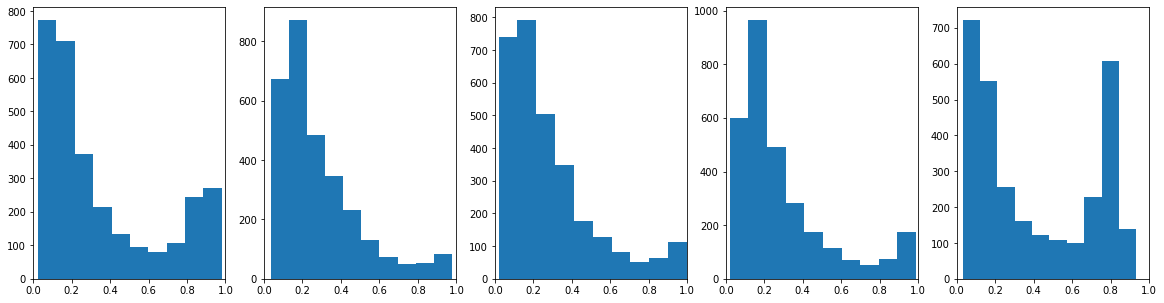

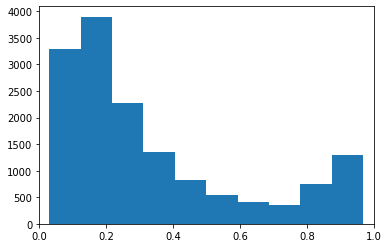

0    11662
1     3337
dtype: int64


In [350]:
num =len(result[3])
fig, axes =plt.subplots(1,num,figsize=(20,5))
for v in range(num):
    axes[v].hist(result[3][v])
    axes[v].set_xlim(0,1)
plt.show()

plt.hist(result[0])
plt.xlim(0,1)
plt.show()
print(pd.DataFrame(np.where(result[0]>0.5,1,0)).value_counts())

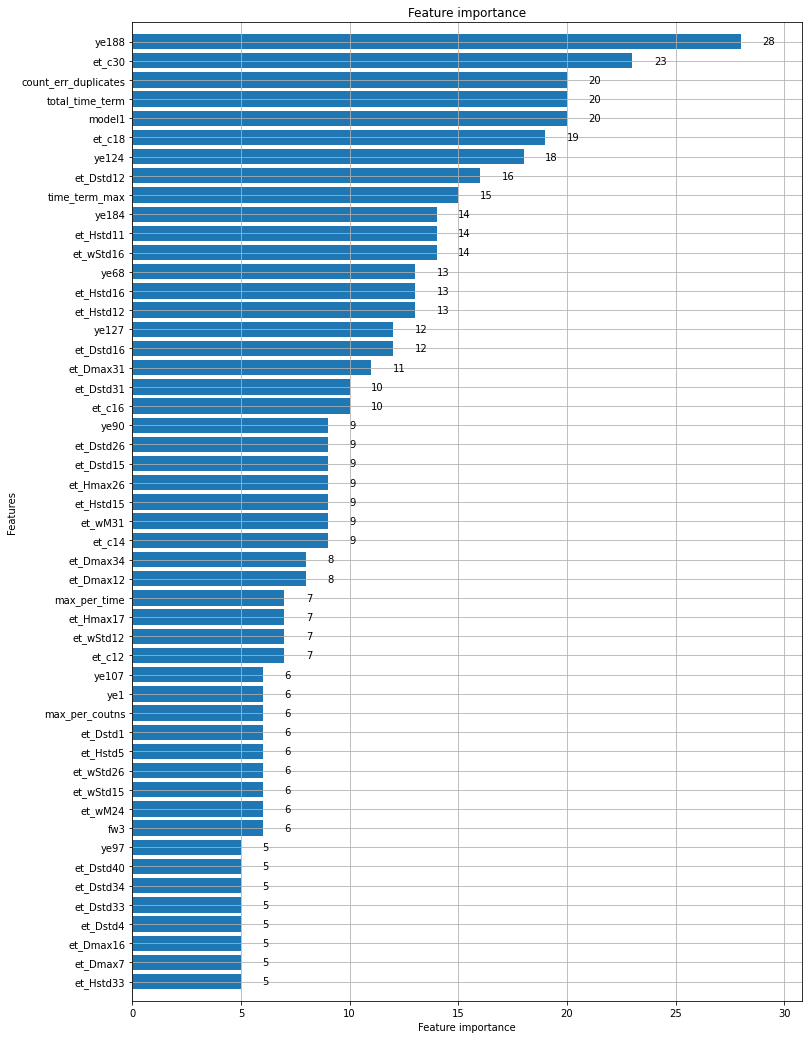

In [351]:
fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(result[2][4], max_num_features=50, height=0.8, ax=ax)
plt.show()

# psue label

In [196]:
train_x = train_data
train_y = label.reshape(-1)
test_x = test_data

base_seed1 = 1015
base_seed2 = 42

def psue_pred(train_x,test_x,train_y,seed1,seed2,feature_names,save_mode='off'):
    # Train
    #-------------------------------------------------------------------------------------
    # validation auc score를 확인하기 위해 정의
    def f_pr_auc(probas_pred, y_true):
        labels=y_true.get_label()
        p, r, _ = precision_recall_curve(labels, probas_pred)
        score=auc(r,p) 
        return "pr_auc", score, True
    #-------------------------------------------------------------------------------------
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': seed1
                    }
    
#     params = {'learning_rate': 0.001,
#           'max_depth': 16,
#           'boosting': 'gbdt',
#           'objective': 'binary',
#           'metric': 'auc',
# #           'is_training_metric': True,
#           'num_leaves': 144,
#           'feature_fraction': 0.9,
#           'bagging_fraction': 0.7,
#           'bagging_freq': 5,
#           'seed':2020}
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=5, shuffle=True, random_state=seed2)
    for train_idx, val_idx in k_fold.split(train_x):

        # split train, validation set
        X = train_x[train_idx]
        y = train_y[train_idx]
        valid_x = train_x[val_idx]
        valid_y = train_y[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 20, 
                            early_stopping_rounds = 30,
                            feature_name =feature_names
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
#         recall    = recall_score(    valid_y, valid_pred)
#         precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
#         recalls.append(recall)
#         precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    print()
    print('ensemble of model auc : ',np.mean(auc_scores))
        
    # 예측
    pred_y_list = []
    for model in models:
        pred_y = model.predict(test_x)
        pred_y_list.append(pred_y.reshape(-1,1))
        

    pred_ensemble = np.mean(pred_y_list, axis = 0)
    predict_ensemble = np.where(pred_ensemble>0.5,1,0)
    
    train_x_psue = np.concatenate(tuple([train_x,test_x]),axis=0)
    train_y_psue = np.append(train_y,predict_ensemble)
    
    
    
    #-------------------------------------------------------------------------------------
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    # 파라미터 설정
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': seed1
                    }
    
#     params = {'learning_rate': 0.001,
#           'max_depth': 16,
#           'boosting': 'gbdt',
#           'objective': 'binary',
#           'metric': 'auc',
# #           'is_training_metric': True,
#           'num_leaves': 144,
#           'feature_fraction': 0.9,
#           'bagging_fraction': 0.7,
#           'bagging_freq': 5,
#           'seed':2020}
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=5, shuffle=True, random_state=seed2)
    for train_idx, val_idx in k_fold.split(train_x):

        # split train, validation set
        X = train_x_psue[train_idx]
        y = train_y_psue[train_idx]
        valid_x = train_x_psue[val_idx]
        valid_y = train_y_psue[val_idx]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)

        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 20, 
                            early_stopping_rounds = 30,
                            feature_name =feature_names
                           )

        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
#         recall    = recall_score(    valid_y, valid_pred)
#         precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
#         recalls.append(recall)
#         precisions.append(precision)
        auc_scores.append(auc_score)

        print('==========================================================')
        
    print()
    print('ensemble of model auc : ',np.mean(auc_scores))    
    
    
    
    
    # 예측
    pred_y_list = []
    for model in models:
        pred_y = model.predict(test_x)
        pred_y_list.append(pred_y.reshape(-1,1))
        

    name = str(datetime.datetime.now())[:-10]
    name =name.replace("-","_").replace(" ","_").replace(":","_")
    pred_ensemble = np.mean(pred_y_list, axis = 0)

    
    
    
    
    
    
    if save_mode =='on':
        sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
        sample_submssion['problem'] = pred_ensemble.reshape(-1)
        save_name= name+"_pseu_%s_%s"%(seed1,seed2)+".csv"
        sample_submssion.to_csv(SAVE_PATH+save_name, index = False)
        print(save_name)
    else:
        print("Done save result")
    return [pred_ensemble ,auc_scores]

In [173]:
re=psue_pred(train_x,test_x,train_y,base_seed1,base_seed2,feature_name_lst,'on')

[LightGBM] [Info] Number of positive: 3633, number of negative: 8367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43034
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 388
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302750 -> initscore=-0.834237
[LightGBM] [Info] Start training from score -0.834237
Training until validation scores don't improve for 30 rounds
[20]	valid_0's auc: 0.82048	valid_0's pr_auc: 0.815395
[40]	valid_0's auc: 0.826438	valid_0's pr_auc: 0.824723
[60]	valid_0's auc: 0.82449	valid_0's pr_auc: 0.821673
Early stopping, best iteration is:
[38]	valid_0's auc: 0.826258	valid_0's pr_auc: 0.825372
[LightGBM] [Info] Number of positive: 4828, number of negative: 7172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017496 seconds.
You can s

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189750 -> initscore=-1.451635
[LightGBM] [Info] Start training from score -1.451635
Training until validation scores don't improve for 30 rounds
[20]	valid_0's auc: 0.826142	valid_0's pr_auc: 0.977421
[40]	valid_0's auc: 0.835291	valid_0's pr_auc: 0.9794
[60]	valid_0's auc: 0.834482	valid_0's pr_auc: 0.979357
Early stopping, best iteration is:
[37]	valid_0's auc: 0.836278	valid_0's pr_auc: 0.979745

ensemble of model auc :  0.8274522024679726
2021_01_25_02_32_pseu_1015_42.csv


In [230]:
# pd.DataFrame(train_x).to_csv("./data/0121train.csv",index=0)

# pd.DataFrame(train_y).to_csv("./data/0121train_y.csv",index=0)

# pd.DataFrame(test_x).to_csv("./data/0121test.csv",index=0)

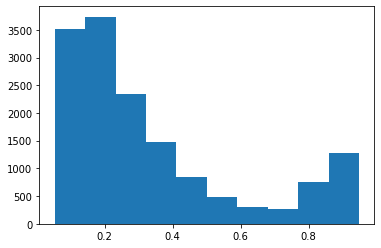

0    11932
1     3067
dtype: int64


In [174]:
plt.hist(re[0])
plt.show()
print(pd.DataFrame(np.where(re[0]>0.5,1,0)).value_counts())

In [136]:
# %%time
# to =[]
# for v in range(40):
#     seed1 =1015 #random.randint(0,2000)
#     seed2 =random.randint(0,2000)
    
#     result = pred(train_x,test_x,train_y,seed1,seed2)
#     to +=[result+[(seed1,seed2)]]

[LightGBM] [Info] Number of positive: 4023, number of negative: 7977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42008
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335250 -> initscore=-0.684535
[LightGBM] [Info] Start training from score -0.684535
[1]	valid_0's auc: 0.790881	valid_0's pr_auc: 0.713364
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.797822	valid_0's pr_auc: 0.718339
[3]	valid_0's auc: 0.801063	valid_0's pr_auc: 0.720488
[4]	valid_0's auc: 0.806729	valid_0's pr_auc: 0.72276
[5]	valid_0's auc: 0.810773	valid_0's pr_auc: 0.726168
[6]	valid_0's auc: 0.810338	valid_0's pr_auc: 0.726656
[7]	valid_0's auc: 0.810644	valid_0's pr_auc: 0.72613
[8]	valid_0's auc: 0.812171	valid_0's pr_auc: 0.727795
[9]	v

[LightGBM] [Info] Number of positive: 3959, number of negative: 8041
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41706
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329917 -> initscore=-0.708562
[LightGBM] [Info] Start training from score -0.708562
[1]	valid_0's auc: 0.781835	valid_0's pr_auc: 0.708477
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.788919	valid_0's pr_auc: 0.715323
[3]	valid_0's auc: 0.791594	valid_0's pr_auc: 0.718009
[4]	valid_0's auc: 0.797938	valid_0's pr_auc: 0.72298
[5]	valid_0's auc: 0.799402	valid_0's pr_auc: 0.724026
[6]	valid_0's auc: 0.802085	valid_0's pr_auc: 0.722075
[7]	valid_0's auc: 0.801732	valid_0's pr_auc: 0.723238
[8]	valid_0's auc: 0.803534	valid_0's pr_auc: 0.72411
[9]	v

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330917 -> initscore=-0.704042
[LightGBM] [Info] Start training from score -0.704042
[1]	valid_0's auc: 0.77923	valid_0's pr_auc: 0.702151
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.783667	valid_0's pr_auc: 0.705102
[3]	valid_0's auc: 0.786788	valid_0's pr_auc: 0.7078
[4]	valid_0's auc: 0.790957	valid_0's pr_auc: 0.711212
[5]	valid_0's auc: 0.79511	valid_0's pr_auc: 0.714781
[6]	valid_0's auc: 0.797678	valid_0's pr_auc: 0.721908
[7]	valid_0's auc: 0.799895	valid_0's pr_auc: 0.723189
[8]	valid_0's auc: 0.801542	valid_0's pr_auc: 0.725173
[9]	valid_0's auc: 0.802691	valid_0's pr_auc: 0.726174
[10]	valid_0's auc: 0.80285	valid_0's pr_auc: 0.726746
[11]	valid_0's auc: 0.80289	valid_0's pr_auc: 0.723389
[12]	valid_0's auc: 0.803849	valid_0's pr_auc: 0.720504
[13]	valid_0's auc: 0.804498	valid_0's pr_auc: 0.725457
Early stopping, best iteration is:
[10]	valid_0's auc: 0.80285	valid_0's pr_auc: 0.726746
[Li

[12]	valid_0's auc: 0.809293	valid_0's pr_auc: 0.735446
[13]	valid_0's auc: 0.809392	valid_0's pr_auc: 0.7359
[14]	valid_0's auc: 0.810527	valid_0's pr_auc: 0.737718
[15]	valid_0's auc: 0.810689	valid_0's pr_auc: 0.735065
[16]	valid_0's auc: 0.811878	valid_0's pr_auc: 0.735428
[17]	valid_0's auc: 0.811794	valid_0's pr_auc: 0.734174
Early stopping, best iteration is:
[14]	valid_0's auc: 0.810527	valid_0's pr_auc: 0.737718
[LightGBM] [Info] Number of positive: 3975, number of negative: 8025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41641
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331250 -> initscore=-0.702537
[LightGBM] [Info] Start training from score -0.702537
[1]	valid_0's auc: 0.791015	valid_0's pr_auc: 0.712305
Training until validati

[10]	valid_0's auc: 0.820799	valid_0's pr_auc: 0.737165
[11]	valid_0's auc: 0.821767	valid_0's pr_auc: 0.738067
[12]	valid_0's auc: 0.821504	valid_0's pr_auc: 0.734823
Early stopping, best iteration is:
[9]	valid_0's auc: 0.820318	valid_0's pr_auc: 0.738713
[LightGBM] [Info] Number of positive: 4018, number of negative: 7982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41732
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334833 -> initscore=-0.686405
[LightGBM] [Info] Start training from score -0.686405
[1]	valid_0's auc: 0.78002	valid_0's pr_auc: 0.689208
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.792314	valid_0's pr_auc: 0.705631
[3]	valid_0's auc: 0.795462	valid_0's pr_auc: 0.706975
[4]	valid_0's auc: 0.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41739
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333083 -> initscore=-0.694272
[LightGBM] [Info] Start training from score -0.694272
[1]	valid_0's auc: 0.79914	valid_0's pr_auc: 0.724973
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.806438	valid_0's pr_auc: 0.731292
[3]	valid_0's auc: 0.810089	valid_0's pr_auc: 0.73092
[4]	valid_0's auc: 0.813111	valid_0's pr_auc: 0.733109
[5]	valid_0's auc: 0.815752	valid_0's pr_auc: 0.735926
[6]	valid_0's auc: 0.816108	valid_0's pr_auc: 0.743446
[7]	valid_0's auc: 0.816911	valid_0's pr_auc: 0.744621
[8]	valid_0's auc: 0.817697	valid_0's pr_auc: 0.745257
[9]	valid_0's auc: 0.818599	valid_0's pr_auc: 0.746316
[10]	valid_0's auc:

[14]	valid_0's auc: 0.819258	valid_0's pr_auc: 0.748994
[15]	valid_0's auc: 0.819518	valid_0's pr_auc: 0.747626
[16]	valid_0's auc: 0.820064	valid_0's pr_auc: 0.748749
[17]	valid_0's auc: 0.820081	valid_0's pr_auc: 0.748611
Early stopping, best iteration is:
[14]	valid_0's auc: 0.819258	valid_0's pr_auc: 0.748994
[LightGBM] [Info] Number of positive: 4014, number of negative: 7986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41721
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334500 -> initscore=-0.687902
[LightGBM] [Info] Start training from score -0.687902
[1]	valid_0's auc: 0.784198	valid_0's pr_auc: 0.703302
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.797802	valid_0's pr_auc: 0.70636
[3]	valid_0's auc: 

[LightGBM] [Info] Number of positive: 3993, number of negative: 8007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41684
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332750 -> initscore=-0.695773
[LightGBM] [Info] Start training from score -0.695773
[1]	valid_0's auc: 0.783893	valid_0's pr_auc: 0.705832
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.789284	valid_0's pr_auc: 0.710631
[3]	valid_0's auc: 0.791399	valid_0's pr_auc: 0.712915
[4]	valid_0's auc: 0.796494	valid_0's pr_auc: 0.716844
[5]	valid_0's auc: 0.80132	valid_0's pr_auc: 0.720351
[6]	valid_0's auc: 0.801568	valid_0's pr_auc: 0.725265
[7]	valid_0's auc: 0.803207	valid_0's pr_auc: 0.725474
[8]	valid_0's auc: 0.806121	valid_0's pr_auc: 0.729569
[9]	

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41946
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334167 -> initscore=-0.689400
[LightGBM] [Info] Start training from score -0.689400
[1]	valid_0's auc: 0.787772	valid_0's pr_auc: 0.71331
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.796255	valid_0's pr_auc: 0.724904
[3]	valid_0's auc: 0.799588	valid_0's pr_auc: 0.725269
[4]	valid_0's auc: 0.805001	valid_0's pr_auc: 0.729095
[5]	valid_0's auc: 0.80798	valid_0's pr_auc: 0.730112
[6]	valid_0's auc: 0.809862	valid_0's pr_auc: 0.731228
[7]	valid_0's auc: 0.810083	valid_0's pr_auc: 0.730708
[8]	valid_0's auc: 0.812683	valid_0's pr_auc: 0.731824
[9]	valid_0's auc: 0.813361	valid_0's pr_auc: 0.733894
[10]	valid_0's auc:

[LightGBM] [Info] Total Bins 41787
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331917 -> initscore=-0.699529
[LightGBM] [Info] Start training from score -0.699529
[1]	valid_0's auc: 0.792776	valid_0's pr_auc: 0.712746
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.80807	valid_0's pr_auc: 0.726747
[3]	valid_0's auc: 0.812781	valid_0's pr_auc: 0.730504
[4]	valid_0's auc: 0.813638	valid_0's pr_auc: 0.731848
[5]	valid_0's auc: 0.813985	valid_0's pr_auc: 0.732605
[6]	valid_0's auc: 0.815892	valid_0's pr_auc: 0.734803
[7]	valid_0's auc: 0.817581	valid_0's pr_auc: 0.736561
[8]	valid_0's auc: 0.81992	valid_0's pr_auc: 0.745714
[9]	valid_0's auc: 0.821293	valid_0's pr_auc: 0.747758
[10]	valid_0's auc: 0.822873	valid_0's pr_auc: 0.747757
[11]	valid_0's auc: 0.823728	valid_0's pr_auc: 0.750361
[12]	valid_0's auc: 0.824126	valid_0's pr_auc: 0.751497
[13]	valid_0's a

[LightGBM] [Info] Number of positive: 3993, number of negative: 8007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41715
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332750 -> initscore=-0.695773
[LightGBM] [Info] Start training from score -0.695773
[1]	valid_0's auc: 0.785909	valid_0's pr_auc: 0.713259
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.788895	valid_0's pr_auc: 0.722039
[3]	valid_0's auc: 0.797233	valid_0's pr_auc: 0.727399
[4]	valid_0's auc: 0.800184	valid_0's pr_auc: 0.729703
[5]	valid_0's auc: 0.803511	valid_0's pr_auc: 0.731516
[6]	valid_0's auc: 0.805871	valid_0's pr_auc: 0.733565
[7]	valid_0's auc: 0.807242	valid_0's pr_auc: 0.73369
[8]	valid_0's auc: 0.808762	valid_0's pr_auc: 0.735183
[9]	

[LightGBM] [Info] Number of positive: 3997, number of negative: 8003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41550
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333083 -> initscore=-0.694272
[LightGBM] [Info] Start training from score -0.694272
[1]	valid_0's auc: 0.791319	valid_0's pr_auc: 0.715404
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.79568	valid_0's pr_auc: 0.723551
[3]	valid_0's auc: 0.796764	valid_0's pr_auc: 0.72391
[4]	valid_0's auc: 0.805563	valid_0's pr_auc: 0.735264
[5]	valid_0's auc: 0.806499	valid_0's pr_auc: 0.735335
[6]	valid_0's auc: 0.807389	valid_0's pr_auc: 0.735804
[7]	valid_0's auc: 0.81071	valid_0's pr_auc: 0.737996
[8]	valid_0's auc: 0.811886	valid_0's pr_auc: 0.738562
[9]	va

[LightGBM] [Info] Number of positive: 4015, number of negative: 7985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41694
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334583 -> initscore=-0.687527
[LightGBM] [Info] Start training from score -0.687527
[1]	valid_0's auc: 0.782676	valid_0's pr_auc: 0.692821
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.791949	valid_0's pr_auc: 0.697612
[3]	valid_0's auc: 0.795531	valid_0's pr_auc: 0.701215
[4]	valid_0's auc: 0.794841	valid_0's pr_auc: 0.700708
[5]	valid_0's auc: 0.796443	valid_0's pr_auc: 0.703511
[6]	valid_0's auc: 0.799936	valid_0's pr_auc: 0.705732
[7]	valid_0's auc: 0.803228	valid_0's pr_auc: 0.705684
[8]	valid_0's auc: 0.806202	valid_0's pr_auc: 0.714055
[9]

[7]	valid_0's auc: 0.806242	valid_0's pr_auc: 0.735913
[8]	valid_0's auc: 0.807772	valid_0's pr_auc: 0.737138
[9]	valid_0's auc: 0.810409	valid_0's pr_auc: 0.738786
[10]	valid_0's auc: 0.810777	valid_0's pr_auc: 0.739039
[11]	valid_0's auc: 0.812046	valid_0's pr_auc: 0.73916
[12]	valid_0's auc: 0.812915	valid_0's pr_auc: 0.738963
[13]	valid_0's auc: 0.813547	valid_0's pr_auc: 0.738216
[14]	valid_0's auc: 0.813859	valid_0's pr_auc: 0.743383
[15]	valid_0's auc: 0.813645	valid_0's pr_auc: 0.743572
[16]	valid_0's auc: 0.815749	valid_0's pr_auc: 0.746338
[17]	valid_0's auc: 0.816116	valid_0's pr_auc: 0.746065
[18]	valid_0's auc: 0.8167	valid_0's pr_auc: 0.747023
[19]	valid_0's auc: 0.817417	valid_0's pr_auc: 0.747804
[20]	valid_0's auc: 0.817754	valid_0's pr_auc: 0.74709
[21]	valid_0's auc: 0.818573	valid_0's pr_auc: 0.74793
[22]	valid_0's auc: 0.818179	valid_0's pr_auc: 0.747351
[23]	valid_0's auc: 0.818199	valid_0's pr_auc: 0.746694
[24]	valid_0's auc: 0.81829	valid_0's pr_auc: 0.74926
Ea

[7]	valid_0's auc: 0.808548	valid_0's pr_auc: 0.732945
[8]	valid_0's auc: 0.810881	valid_0's pr_auc: 0.735186
[9]	valid_0's auc: 0.812047	valid_0's pr_auc: 0.737819
[10]	valid_0's auc: 0.813527	valid_0's pr_auc: 0.738546
[11]	valid_0's auc: 0.814098	valid_0's pr_auc: 0.737929
[12]	valid_0's auc: 0.815392	valid_0's pr_auc: 0.742714
[13]	valid_0's auc: 0.815612	valid_0's pr_auc: 0.742197
[14]	valid_0's auc: 0.815866	valid_0's pr_auc: 0.741855
[15]	valid_0's auc: 0.816021	valid_0's pr_auc: 0.74317
[16]	valid_0's auc: 0.817022	valid_0's pr_auc: 0.745706
[17]	valid_0's auc: 0.816797	valid_0's pr_auc: 0.745727
[18]	valid_0's auc: 0.816883	valid_0's pr_auc: 0.745433
[19]	valid_0's auc: 0.817677	valid_0's pr_auc: 0.746509
[20]	valid_0's auc: 0.818809	valid_0's pr_auc: 0.748584
[21]	valid_0's auc: 0.819316	valid_0's pr_auc: 0.746899
[22]	valid_0's auc: 0.819637	valid_0's pr_auc: 0.748195
[23]	valid_0's auc: 0.818906	valid_0's pr_auc: 0.746441
Early stopping, best iteration is:
[20]	valid_0's au

[9]	valid_0's auc: 0.812721	valid_0's pr_auc: 0.725469
[10]	valid_0's auc: 0.813061	valid_0's pr_auc: 0.725555
Early stopping, best iteration is:
[7]	valid_0's auc: 0.812162	valid_0's pr_auc: 0.726642
[LightGBM] [Info] Number of positive: 4012, number of negative: 7988
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41625
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334333 -> initscore=-0.688651
[LightGBM] [Info] Start training from score -0.688651
[1]	valid_0's auc: 0.779143	valid_0's pr_auc: 0.690962
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.784061	valid_0's pr_auc: 0.694948
[3]	valid_0's auc: 0.787569	valid_0's pr_auc: 0.696131
[4]	valid_0's auc: 0.790682	valid_0's pr_auc: 0.702176
[5]	valid_0's auc: 0.7

[9]	valid_0's auc: 0.816797	valid_0's pr_auc: 0.74702
[10]	valid_0's auc: 0.817361	valid_0's pr_auc: 0.746749
[11]	valid_0's auc: 0.817055	valid_0's pr_auc: 0.745935
[12]	valid_0's auc: 0.817876	valid_0's pr_auc: 0.746282
Early stopping, best iteration is:
[9]	valid_0's auc: 0.816797	valid_0's pr_auc: 0.74702
[LightGBM] [Info] Number of positive: 3970, number of negative: 8030
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41663
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330833 -> initscore=-0.704418
[LightGBM] [Info] Start training from score -0.704418
[1]	valid_0's auc: 0.783036	valid_0's pr_auc: 0.710834
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.78543	valid_0's pr_auc: 0.714852
[3]	valid_0's auc: 0.79

[20]	valid_0's auc: 0.831228	valid_0's pr_auc: 0.758048
[21]	valid_0's auc: 0.832121	valid_0's pr_auc: 0.76202
[22]	valid_0's auc: 0.832561	valid_0's pr_auc: 0.759863
[23]	valid_0's auc: 0.832581	valid_0's pr_auc: 0.759605
[24]	valid_0's auc: 0.833436	valid_0's pr_auc: 0.760504
Early stopping, best iteration is:
[21]	valid_0's auc: 0.832121	valid_0's pr_auc: 0.76202
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41720
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[1]	valid_0's auc: 0.795398	valid_0's pr_auc: 0.703553
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 

[12]	valid_0's auc: 0.806391	valid_0's pr_auc: 0.734199
[13]	valid_0's auc: 0.807275	valid_0's pr_auc: 0.730233
[14]	valid_0's auc: 0.808409	valid_0's pr_auc: 0.734776
[15]	valid_0's auc: 0.80889	valid_0's pr_auc: 0.732082
[16]	valid_0's auc: 0.809714	valid_0's pr_auc: 0.735595
[17]	valid_0's auc: 0.809679	valid_0's pr_auc: 0.736286
[18]	valid_0's auc: 0.810451	valid_0's pr_auc: 0.737384
[19]	valid_0's auc: 0.811352	valid_0's pr_auc: 0.737804
[20]	valid_0's auc: 0.811579	valid_0's pr_auc: 0.738526
[21]	valid_0's auc: 0.812544	valid_0's pr_auc: 0.739472
[22]	valid_0's auc: 0.812919	valid_0's pr_auc: 0.739804
[23]	valid_0's auc: 0.813432	valid_0's pr_auc: 0.742521
[24]	valid_0's auc: 0.813841	valid_0's pr_auc: 0.742917
[25]	valid_0's auc: 0.814307	valid_0's pr_auc: 0.744618
[26]	valid_0's auc: 0.814488	valid_0's pr_auc: 0.744411
[27]	valid_0's auc: 0.814793	valid_0's pr_auc: 0.746062
[28]	valid_0's auc: 0.814887	valid_0's pr_auc: 0.746109
[29]	valid_0's auc: 0.814864	valid_0's pr_auc: 0.

[21]	valid_0's auc: 0.827957	valid_0's pr_auc: 0.750932
[22]	valid_0's auc: 0.828162	valid_0's pr_auc: 0.751408
Early stopping, best iteration is:
[19]	valid_0's auc: 0.827748	valid_0's pr_auc: 0.751732
[LightGBM] [Info] Number of positive: 3990, number of negative: 8010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41636
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.332500 -> initscore=-0.696900
[LightGBM] [Info] Start training from score -0.696900
[1]	valid_0's auc: 0.793059	valid_0's pr_auc: 0.720393
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.799095	valid_0's pr_auc: 0.728512
[3]	valid_0's auc: 0.802495	valid_0's pr_auc: 0.728166
[4]	valid_0's auc: 0.808941	valid_0's pr_auc: 0.733226
[5]	valid_0's auc: 0

[LightGBM] [Info] Number of positive: 4014, number of negative: 7986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41870
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334500 -> initscore=-0.687902
[LightGBM] [Info] Start training from score -0.687902
[1]	valid_0's auc: 0.781962	valid_0's pr_auc: 0.701008
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.791255	valid_0's pr_auc: 0.709055
[3]	valid_0's auc: 0.793952	valid_0's pr_auc: 0.714129
[4]	valid_0's auc: 0.799059	valid_0's pr_auc: 0.716847
[5]	valid_0's auc: 0.799425	valid_0's pr_auc: 0.717851
[6]	valid_0's auc: 0.800711	valid_0's pr_auc: 0.71832
[7]	valid_0's auc: 0.80196	valid_0's pr_auc: 0.719371
[8]	valid_0's auc: 0.803191	valid_0's pr_auc: 0.721658
[9]	v

[8]	valid_0's auc: 0.820443	valid_0's pr_auc: 0.730407
[9]	valid_0's auc: 0.821104	valid_0's pr_auc: 0.729521
[10]	valid_0's auc: 0.820894	valid_0's pr_auc: 0.725176
Early stopping, best iteration is:
[7]	valid_0's auc: 0.818709	valid_0's pr_auc: 0.731438
[LightGBM] [Info] Number of positive: 4000, number of negative: 8000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42206
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[1]	valid_0's auc: 0.782665	valid_0's pr_auc: 0.709656
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.796922	valid_0's pr_auc: 0.719719
[3]	valid_0's auc: 0.796136	valid_0's pr_auc: 0.718036
[4]	valid_0's auc: 0.8

[LightGBM] [Info] Number of positive: 4026, number of negative: 7974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42055
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335500 -> initscore=-0.683413
[LightGBM] [Info] Start training from score -0.683413
[1]	valid_0's auc: 0.785547	valid_0's pr_auc: 0.699059
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.79354	valid_0's pr_auc: 0.705047
[3]	valid_0's auc: 0.79919	valid_0's pr_auc: 0.707693
[4]	valid_0's auc: 0.798613	valid_0's pr_auc: 0.70811
[5]	valid_0's auc: 0.800614	valid_0's pr_auc: 0.709845
[6]	valid_0's auc: 0.801465	valid_0's pr_auc: 0.71094
[7]	valid_0's auc: 0.802214	valid_0's pr_auc: 0.710749
[8]	valid_0's auc: 0.802213	valid_0's pr_auc: 0.709173
[9]	val

[LightGBM] [Info] Number of positive: 4020, number of negative: 7980
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41730
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335000 -> initscore=-0.685657
[LightGBM] [Info] Start training from score -0.685657
[1]	valid_0's auc: 0.788587	valid_0's pr_auc: 0.711338
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.795791	valid_0's pr_auc: 0.717607
[3]	valid_0's auc: 0.803253	valid_0's pr_auc: 0.716664
[4]	valid_0's auc: 0.803443	valid_0's pr_auc: 0.717655
[5]	valid_0's auc: 0.805079	valid_0's pr_auc: 0.71833
[6]	valid_0's auc: 0.806821	valid_0's pr_auc: 0.723246
[7]	valid_0's auc: 0.808057	valid_0's pr_auc: 0.723076
[8]	valid_0's auc: 0.810208	valid_0's pr_auc: 0.725338
[9]	

[11]	valid_0's auc: 0.808543	valid_0's pr_auc: 0.717626
[12]	valid_0's auc: 0.809494	valid_0's pr_auc: 0.718816
[13]	valid_0's auc: 0.809487	valid_0's pr_auc: 0.716039
[14]	valid_0's auc: 0.810177	valid_0's pr_auc: 0.71627
[15]	valid_0's auc: 0.811395	valid_0's pr_auc: 0.718527
Early stopping, best iteration is:
[12]	valid_0's auc: 0.809494	valid_0's pr_auc: 0.718816
[LightGBM] [Info] Number of positive: 3976, number of negative: 8024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41709
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331333 -> initscore=-0.702161
[LightGBM] [Info] Start training from score -0.702161
[1]	valid_0's auc: 0.801585	valid_0's pr_auc: 0.733151
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc:

[LightGBM] [Info] Number of positive: 4021, number of negative: 7979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41819
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335083 -> initscore=-0.685282
[LightGBM] [Info] Start training from score -0.685282
[1]	valid_0's auc: 0.799596	valid_0's pr_auc: 0.733067
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.805998	valid_0's pr_auc: 0.733542
[3]	valid_0's auc: 0.813703	valid_0's pr_auc: 0.741249
[4]	valid_0's auc: 0.816928	valid_0's pr_auc: 0.743748
[5]	valid_0's auc: 0.817818	valid_0's pr_auc: 0.749404
[6]	valid_0's auc: 0.819526	valid_0's pr_auc: 0.75062
[7]	valid_0's auc: 0.820106	valid_0's pr_auc: 0.746801
[8]	valid_0's auc: 0.820751	valid_0's pr_auc: 0.750962
[9]	

[LightGBM] [Info] Number of positive: 4078, number of negative: 7922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41707
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339833 -> initscore=-0.664037
[LightGBM] [Info] Start training from score -0.664037
[1]	valid_0's auc: 0.809367	valid_0's pr_auc: 0.719402
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.809701	valid_0's pr_auc: 0.719441
[3]	valid_0's auc: 0.810992	valid_0's pr_auc: 0.719326
[4]	valid_0's auc: 0.812479	valid_0's pr_auc: 0.720641
[5]	valid_0's auc: 0.812903	valid_0's pr_auc: 0.722454
[6]	valid_0's auc: 0.813344	valid_0's pr_auc: 0.722391
[7]	valid_0's auc: 0.813009	valid_0's pr_auc: 0.72145
[8]	valid_0's auc: 0.812515	valid_0's pr_auc: 0.720726
Earl

[LightGBM] [Info] Number of positive: 4018, number of negative: 7982
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41727
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334833 -> initscore=-0.686405
[LightGBM] [Info] Start training from score -0.686405
[1]	valid_0's auc: 0.786942	valid_0's pr_auc: 0.699621
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.792618	valid_0's pr_auc: 0.703196
[3]	valid_0's auc: 0.799186	valid_0's pr_auc: 0.702857
[4]	valid_0's auc: 0.803085	valid_0's pr_auc: 0.705095
[5]	valid_0's auc: 0.80601	valid_0's pr_auc: 0.707059
[6]	valid_0's auc: 0.809053	valid_0's pr_auc: 0.709009
[7]	valid_0's auc: 0.810272	valid_0's pr_auc: 0.714775
[8]	valid_0's auc: 0.811715	valid_0's pr_auc: 0.716329
[9]	

[14]	valid_0's auc: 0.821701	valid_0's pr_auc: 0.756517
[15]	valid_0's auc: 0.822947	valid_0's pr_auc: 0.757298
[16]	valid_0's auc: 0.822128	valid_0's pr_auc: 0.755312
[17]	valid_0's auc: 0.822727	valid_0's pr_auc: 0.755645
[18]	valid_0's auc: 0.823613	valid_0's pr_auc: 0.756825
Early stopping, best iteration is:
[15]	valid_0's auc: 0.822947	valid_0's pr_auc: 0.757298
[LightGBM] [Info] Number of positive: 3962, number of negative: 8038
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41700
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330167 -> initscore=-0.707431
[LightGBM] [Info] Start training from score -0.707431
[1]	valid_0's auc: 0.789136	valid_0's pr_auc: 0.734399
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc

[10]	valid_0's auc: 0.797787	valid_0's pr_auc: 0.707246
[11]	valid_0's auc: 0.799483	valid_0's pr_auc: 0.711414
[12]	valid_0's auc: 0.79943	valid_0's pr_auc: 0.71299
[13]	valid_0's auc: 0.799317	valid_0's pr_auc: 0.713951
[14]	valid_0's auc: 0.8001	valid_0's pr_auc: 0.714544
[15]	valid_0's auc: 0.800413	valid_0's pr_auc: 0.714955
[16]	valid_0's auc: 0.800505	valid_0's pr_auc: 0.713991
[17]	valid_0's auc: 0.800802	valid_0's pr_auc: 0.70727
[18]	valid_0's auc: 0.800473	valid_0's pr_auc: 0.706555
Early stopping, best iteration is:
[15]	valid_0's auc: 0.800413	valid_0's pr_auc: 0.714955
[LightGBM] [Info] Number of positive: 3969, number of negative: 8031
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41662
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg

[11]	valid_0's auc: 0.820718	valid_0's pr_auc: 0.741307
[12]	valid_0's auc: 0.820197	valid_0's pr_auc: 0.741124
Early stopping, best iteration is:
[9]	valid_0's auc: 0.819966	valid_0's pr_auc: 0.742183
[LightGBM] [Info] Number of positive: 4010, number of negative: 7990
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41678
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334167 -> initscore=-0.689400
[LightGBM] [Info] Start training from score -0.689400
[1]	valid_0's auc: 0.780472	valid_0's pr_auc: 0.701467
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.788587	valid_0's pr_auc: 0.714796
[3]	valid_0's auc: 0.794101	valid_0's pr_auc: 0.720188
[4]	valid_0's auc: 0.800789	valid_0's pr_auc: 0.72319
[5]	valid_0's auc: 0.8

[25]	valid_0's auc: 0.818749	valid_0's pr_auc: 0.743856
[26]	valid_0's auc: 0.818968	valid_0's pr_auc: 0.74465
[27]	valid_0's auc: 0.819053	valid_0's pr_auc: 0.746249
[28]	valid_0's auc: 0.819458	valid_0's pr_auc: 0.746879
[29]	valid_0's auc: 0.819064	valid_0's pr_auc: 0.747883
[30]	valid_0's auc: 0.819719	valid_0's pr_auc: 0.749349
[31]	valid_0's auc: 0.820228	valid_0's pr_auc: 0.750721
[32]	valid_0's auc: 0.820451	valid_0's pr_auc: 0.751984
[33]	valid_0's auc: 0.820616	valid_0's pr_auc: 0.7521
[34]	valid_0's auc: 0.820695	valid_0's pr_auc: 0.752892
[35]	valid_0's auc: 0.820848	valid_0's pr_auc: 0.753672
[36]	valid_0's auc: 0.82134	valid_0's pr_auc: 0.754015
[37]	valid_0's auc: 0.82104	valid_0's pr_auc: 0.753015
[38]	valid_0's auc: 0.821195	valid_0's pr_auc: 0.753515
[39]	valid_0's auc: 0.821197	valid_0's pr_auc: 0.753944
Early stopping, best iteration is:
[36]	valid_0's auc: 0.82134	valid_0's pr_auc: 0.754015
[LightGBM] [Info] Number of positive: 3987, number of negative: 8013
[Light

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41670
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333417 -> initscore=-0.692772
[LightGBM] [Info] Start training from score -0.692772
[1]	valid_0's auc: 0.786659	valid_0's pr_auc: 0.698445
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.789633	valid_0's pr_auc: 0.701396
[3]	valid_0's auc: 0.794338	valid_0's pr_auc: 0.702837
[4]	valid_0's auc: 0.800233	valid_0's pr_auc: 0.707458
[5]	valid_0's auc: 0.804542	valid_0's pr_auc: 0.71019
[6]	valid_0's auc: 0.807133	valid_0's pr_auc: 0.713283
[7]	valid_0's auc: 0.809883	valid_0's pr_auc: 0.711222
[8]	valid_0's auc: 0.812612	valid_0's pr_auc: 0.71418
[9]	valid_0's auc: 0.813945	valid_0's pr_auc: 0.719658
[10]	valid_0's auc:

[LightGBM] [Info] Number of positive: 4014, number of negative: 7986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41765
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334500 -> initscore=-0.687902
[LightGBM] [Info] Start training from score -0.687902
[1]	valid_0's auc: 0.794751	valid_0's pr_auc: 0.713006
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.798593	valid_0's pr_auc: 0.717432
[3]	valid_0's auc: 0.805596	valid_0's pr_auc: 0.722413
[4]	valid_0's auc: 0.809577	valid_0's pr_auc: 0.724672
[5]	valid_0's auc: 0.811016	valid_0's pr_auc: 0.726913
[6]	valid_0's auc: 0.813696	valid_0's pr_auc: 0.729333
[7]	valid_0's auc: 0.812855	valid_0's pr_auc: 0.729651
[8]	valid_0's auc: 0.813938	valid_0's pr_auc: 0.730786
[9]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333583 -> initscore=-0.692022
[LightGBM] [Info] Start training from score -0.692022
[1]	valid_0's auc: 0.785523	valid_0's pr_auc: 0.697213
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.797549	valid_0's pr_auc: 0.717545
[3]	valid_0's auc: 0.796978	valid_0's pr_auc: 0.716908
[4]	valid_0's auc: 0.800076	valid_0's pr_auc: 0.718021
[5]	valid_0's auc: 0.801632	valid_0's pr_auc: 0.717986
[6]	valid_0's auc: 0.804631	valid_0's pr_auc: 0.721726
[7]	valid_0's auc: 0.804751	valid_0's pr_auc: 0.72096
[8]	valid_0's auc: 0.806388	valid_0's pr_auc: 0.726294
[9]	valid_0's auc: 0.807757	valid_0's pr_auc: 0.723295
[10]	valid_0's auc: 0.80914	valid_0's pr_auc: 0.725179
[11]	valid_0's auc: 0.810322	valid_0's pr_auc: 0.730575
[12]	valid_0's auc: 0.811814	valid_0's pr_auc: 0.735271
[13]	valid_0's auc: 0.813218	valid_0's pr_auc: 0.736658
[14]	valid_0's auc: 0.813777	valid_0's pr_auc: 0.737023
[15]	valid_0's auc: 0.814976	vali

[LightGBM] [Info] Number of positive: 4016, number of negative: 7984
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41800
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334667 -> initscore=-0.687153
[LightGBM] [Info] Start training from score -0.687153
[1]	valid_0's auc: 0.797416	valid_0's pr_auc: 0.709152
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.800486	valid_0's pr_auc: 0.716418
[3]	valid_0's auc: 0.808691	valid_0's pr_auc: 0.724821
[4]	valid_0's auc: 0.810745	valid_0's pr_auc: 0.725458
[5]	valid_0's auc: 0.814779	valid_0's pr_auc: 0.726209
[6]	valid_0's auc: 0.815512	valid_0's pr_auc: 0.732107
[7]	valid_0's auc: 0.816661	valid_0's pr_auc: 0.731905
[8]	valid_0's auc: 0.818205	valid_0's pr_auc: 0.733512
[9]

[LightGBM] [Info] Number of positive: 4034, number of negative: 7966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41678
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 375
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336167 -> initscore=-0.680424
[LightGBM] [Info] Start training from score -0.680424
[1]	valid_0's auc: 0.785336	valid_0's pr_auc: 0.678574
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.799476	valid_0's pr_auc: 0.708694
[3]	valid_0's auc: 0.799873	valid_0's pr_auc: 0.709079
[4]	valid_0's auc: 0.803425	valid_0's pr_auc: 0.712723
[5]	valid_0's auc: 0.80564	valid_0's pr_auc: 0.712955
[6]	valid_0's auc: 0.80715	valid_0's pr_auc: 0.715465
[7]	valid_0's auc: 0.808249	valid_0's pr_auc: 0.71471
[8]	valid_0's auc: 0.808299	valid_0's pr_auc: 0.713272
[9]	va

In [739]:
train_time = pd.read_csv('/Users/ds/Documents/data/result/time_train_var.csv').fillna(0)
test_time = pd.read_csv('/Users/ds/Documents/data/result/time_test_var.csv').fillna(0)

In [740]:
train_xxx = np.concatenate(tuple([train_xx,train_time.values]),axis=1)
test_xxx = np.concatenate(tuple([test_xx,test_time.values]),axis=1)

In [741]:
train_xxx.shape

(15000, 616)

In [742]:
train_xxxx = train_xxx[:,5:]
train_xxxx.shape

(15000, 611)

In [8]:
train_x = pd.read_csv('/Users/ds/Documents/data/serverdata/max/train0126_feaeture_615.csv',index_col=0).values
test_x = pd.read_csv('/Users/ds/Documents/data/serverdata/max/test0126_feaeture_615.csv',index_col=0).values
label  = pd.read_csv('/Users/ds/Documents/data/serverdata/label0125_506.csv').values

# kaggle one que

In [67]:
# for i,d in enumerate(datatest):
#     print('%d %d'%((i+1),d.shape[1]))


In [44]:
# npdf = np.load('/Users/ds/Documents/data/result/(20210125)DS_JOIN_tot_x.npz')

# ye_tr = npdf['train_x']
# ye_ts = npdf['test_x']

# train_xx=np.concatenate((train_x,ye_tr),axis=1)
# test_xx=np.concatenate((test_x,ye_ts),axis=1)




feature_name_lst =[]
# name_first = ['fw','model','et_c','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
name_first = ['fw','model','et_c','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
# name_first = ['fw','model','et_wM','et_wStd','et_Hm','et_Hstd','et_Hmax','et_Dm','et_Dmax','et_Dstd']
for v in range(11):
    if datalist[v].shape[1] ==42:
        target_word = name_first[v]
        for et in range(1,43):
            feature_name_lst+=[target_word+str(et)]
            
    else:
        target_word = name_first[v]
        for et in range(datalist[v].shape[1]):
            feature_name_lst+=[target_word+str(et)]
        
        
    print('data %d'%(v+1),datalist[v].shape)

time_term = ['time_term_max','time_term_min','total_time_term','time_count_err_duplicates','time_max_per_coutns','time_max_per_time']
conn_term = ['conn'+str(x) for x in range(18)]
time_term_fw  =['time_fw_1','time_fw_2','time_fw_3','time_fw_4','time_fw_5','time_fw_6']
main_time = ['main_time_err'+str(x+1) for x in range(84)]

feature_name_lst +=['md_counts', 'fw_counts', 'fw_change', 'fw_flows', 'md_flows','fw_mean', 'fw_std']+time_term+conn_term+time_term_fw +main_time+['ye'+str(x) for x in range(194)]

print(len(feature_name_lst))

data 1 (15000, 5)
data 2 (15000, 2)
data 3 (15000, 42)
data 4 (15000, 42)
data 5 (15000, 42)
data 6 (15000, 42)
data 7 (15000, 42)
data 8 (15000, 42)
data 9 (15000, 42)
data 10 (15000, 42)
data 11 (15000, 42)
700


In [9]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [32]:

def model_kaggle(train_set,label,feature_name_lst,seed1):
    name = str(datetime.datetime.now())[:-10] +""
    model_name = 'one_que'

    random_seed_change =314
    from sklearn.model_selection import train_test_split
    idxs = np.arange(15000)
    X_train, X_test, y_train, y_test,idxs_train,idxs_tst = train_test_split(train_set, label,idxs ,test_size=0.20, random_state=random_seed_change, stratify=label)

    
#     from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

#     pt = PowerTransformer()
#     pt.fit(X_train)                       ## Fit the PT on training data
#     X_train = pt.transform(X_train)    ## Then apply on all data
#     X_test = pt.transform(X_test)



    def learning_rate_010_decay_power_099(current_iter):
        base_learning_rate = 0.1
        lr = base_learning_rate  * np.power(.99, current_iter)
        return lr if lr > 1e-4 else 1e-4

    def learning_rate_010_decay_power_0995(current_iter):
        base_learning_rate = 0.1
        lr = base_learning_rate  * np.power(.995, current_iter)
        return lr if lr > 1e-4 else 1e-4

    def learning_rate_005_decay_power_099(current_iter):
        base_learning_rate = 0.05
        lr = base_learning_rate  * np.power(.99, current_iter)
        return lr if lr > 1e-3 else 1e-3

    def learning_rate_010_decay_power_0996(current_iter):
        base_learning_rate = 0.1
        lr = base_learning_rate  * np.power(.996, current_iter)
        return lr if lr > 1e-4 else 1e-4

    
    fit_params={"early_stopping_rounds":30, 
                "eval_metric" : 'auc', 
                "eval_set" : [(X_test,y_test)],
                'eval_names': ['valid'],
                'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0996)],
                'verbose': 100,
                'categorical_feature': 'auto'}




    param_test ={'num_leaves': sp_randint(6, 50), 
                 'min_child_samples': sp_randint(100, 500), 
                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                 'subsample': sp_uniform(loc=0.2, scale=0.8), 
                 'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


    n_HP_points_to_test = 100


    #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
    clf = lgb.LGBMClassifier(max_depth=-1, random_state=seed1, silent=True, metric='None', n_jobs=4, n_estimators=5000)
    gs = RandomizedSearchCV(
        estimator=clf, param_distributions=param_test, 
        n_iter=n_HP_points_to_test,
        scoring='roc_auc',
        cv=3,
        refit=True,
        random_state=random_seed_change,
        verbose=True)



    gs.fit(X_train, y_train, **fit_params)
    print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

    opt_parameters = gs.best_params_
    clf_final = lgb.LGBMClassifier(**clf.get_params())
    clf_final.set_params(**opt_parameters)

    #Train the final model with learning rate decay
    fit_params_final={"early_stopping_rounds":100, 
                "eval_metric" : 'auc', 
                "eval_set" : [(X_test,y_test)],
                'eval_names': ['valid'],
                'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],
                'verbose': 100,
                'categorical_feature': 'auto'}
    
    
    
    clf_final.fit(X_train, y_train, **fit_params_final) #,feature_name =feature_name_lst)

    return clf_final


In [33]:
w=''

In [31]:
models33 =model_kaggle(train_x,label,314,w)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825431
[200]	valid's auc: 0.82821
[300]	valid's auc: 0.829035
[400]	valid's auc: 0.829299
[500]	valid's auc: 0.829382
[600]	valid's auc: 0.829418
[700]	valid's auc: 0.829425
Early stopping, best iteration is:
[683]	valid's auc: 0.829426
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.82601
[200]	valid's auc: 0.827629
[300]	valid's auc: 0.828383
[400]	valid's auc: 0.828608
[500]	valid's auc: 0.828678
[600]	valid's auc: 0.828713
Early stopping, best iteration is:
[664]	valid's auc: 0.828727
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.82573
[200]	valid's auc: 0.828258
[300]	valid's auc: 0.828883
[400]	valid's auc: 0.829034
[500]	valid's auc: 0.82908
Early stopping, best iteration is:
[487]	valid's auc: 0.829088
Training until validation scores don't improve for 30 rounds
[100

Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822877
[200]	valid's auc: 0.825429
[300]	valid's auc: 0.82633
[400]	valid's auc: 0.826608
[500]	valid's auc: 0.82668
[600]	valid's auc: 0.826712
[700]	valid's auc: 0.826734
Early stopping, best iteration is:
[724]	valid's auc: 0.826737
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.823987
[200]	valid's auc: 0.825898
[300]	valid's auc: 0.82625
Early stopping, best iteration is:
[338]	valid's auc: 0.826358
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.821932
[200]	valid's auc: 0.825036
[300]	valid's auc: 0.825727
[400]	valid's auc: 0.825955
[500]	valid'

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.823209
[200]	valid's auc: 0.826073
[300]	valid's auc: 0.826829
[400]	valid's auc: 0.827133
[500]	valid's auc: 0.827229
[600]	valid's auc: 0.827268
[700]	valid's auc: 0.827297
Early stopping, best iteration is:
[719]	valid's auc: 0.8273
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.824694
[200]	valid's auc: 0.826465
[300]	valid's auc: 0.82699
[400]	valid's auc: 0.827113
[500]	valid's auc: 0.827171
Early stopping, best iteration is:
[473]	valid's auc: 0.827175
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825497
[200]	valid's auc: 0.827285
[300]	valid's auc: 0.827723
[400]	valid's auc: 0.827847
Early stopping, best iteration is:
[459]	valid's auc: 0.827889
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.813267
[200]	valid's auc: 0.815908
[300]	valid's auc: 0.816462
[400]	valid's auc: 0.816669
[500]	vali

Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.797116
[200]	valid's auc: 0.798695
Early stopping, best iteration is:
[204]	valid's auc: 0.798727
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.801945
[200]	valid's auc: 0.803464
Early stopping, best iteration is:
[202]	valid's auc: 0.803465
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.800148
Early stopping, best iteration is:
[167]	valid's auc: 0.801092
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.830311
[200]	valid's auc: 0.832093
[300]	valid's auc: 0.832386
[400]	valid's auc: 0.832599
Early stopping, best iteration is:
[435]	valid's auc: 0.832659
Training until validation scores don't improve for 30 rounds
[100]	valid's auc:

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.818192
[200]	valid's auc: 0.819585
Early stopping, best iteration is:
[256]	valid's auc: 0.81967
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.816049
[200]	valid's auc: 0.817149
[300]	valid's auc: 0.817303
Early stopping, best iteration is:
[335]	valid's auc: 0.817315
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.823816
[200]	valid's auc: 0.826133
[300]	valid's auc: 0.82693
[400]	valid's auc: 0.827116
[500]	valid's auc: 0.827203
[600]	valid's auc: 0.827234
Early stopping, best iteration is:
[632]	valid's auc: 0.827245
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825685
[200]	valid's auc: 0.828016
[300]	valid's auc: 0.828444
Early stopping, best iteration is:
[348]	valid's auc: 0.828519
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822965
[200]	valid's auc: 0.8249

[300]	valid's auc: 0.826622
[400]	valid's auc: 0.826766
Early stopping, best iteration is:
[405]	valid's auc: 0.826781
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825249
[200]	valid's auc: 0.826923
[300]	valid's auc: 0.827202
[400]	valid's auc: 0.827303
[500]	valid's auc: 0.827341
Early stopping, best iteration is:
[502]	valid's auc: 0.827345
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822797
[200]	valid's auc: 0.825657
[300]	valid's auc: 0.826607
[400]	valid's auc: 0.826874
[500]	valid's auc: 0.826994
[600]	valid's auc: 0.827033
Early stopping, best iteration is:
[660]	valid's auc: 0.827053
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.824523
[200]	valid's auc: 0.82629
[300]	valid's auc: 0.826715
[400]	valid's auc: 0.826864
[500]	valid's auc: 0.826924
[600]	valid's auc: 0.826947
Early stopping, best iteration is:
[633]	valid's auc: 0.826959
Training until validation scores d

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825277
[200]	valid's auc: 0.827073
[300]	valid's auc: 0.827297
Early stopping, best iteration is:
[296]	valid's auc: 0.827345
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.823551
[200]	valid's auc: 0.826358
[300]	valid's auc: 0.827086
Early stopping, best iteration is:
[307]	valid's auc: 0.82711
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.818798
[200]	valid's auc: 0.820319
[300]	valid's auc: 0.820728
[400]	valid's auc: 0.82084
Early stopping, best iteration is:
[421]	valid's auc: 0.820844
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.820214
[200]	valid's auc: 0.821608
[300]	valid's auc: 0.821975
[400]	valid's auc: 0.822035
[500]	valid's auc: 0.822079
[600]	valid's auc: 0.822098
Early stopping, best iteration is:
[571]	valid's auc: 0.822101
Training until validation scores don't improve for 30 roun

[100]	valid's auc: 0.830416
[200]	valid's auc: 0.831623
Early stopping, best iteration is:
[222]	valid's auc: 0.83173
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.832948
Early stopping, best iteration is:
[77]	valid's auc: 0.833525
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.828263
[200]	valid's auc: 0.829589
[300]	valid's auc: 0.830361
Early stopping, best iteration is:
[369]	valid's auc: 0.830528
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.82709
[200]	valid's auc: 0.828467
Early stopping, best iteration is:
[206]	valid's auc: 0.828538
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.830206
[200]	valid's auc: 0.83192
Early stopping, best iteration is:
[226]	valid's auc: 0.832098
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822333
[200]	valid's auc: 0.824866
[300]	valid's auc: 0.8256
[400]	valid's auc: 0.8

In [34]:
models33 =model_kaggle(train_x,label,314,w)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.827003
[200]	valid's auc: 0.83131
[300]	valid's auc: 0.832112
Early stopping, best iteration is:
[344]	valid's auc: 0.832344
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826376
[200]	valid's auc: 0.828835
Early stopping, best iteration is:
[207]	valid's auc: 0.828906
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.827904
[200]	valid's auc: 0.831157
Early stopping, best iteration is:
[252]	valid's auc: 0.831792
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.829235
[200]	valid's auc: 0.834086
[300]	valid's auc: 0.83522
Early stopping, best iteration is:
[326]	valid's auc: 0.835438
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.827258
[200]	valid's auc: 0.830282
[300]	valid's auc: 0.831283
Early stopping, be

Early stopping, best iteration is:
[859]	valid's auc: 0.826966
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822008
[200]	valid's auc: 0.825215
[300]	valid's auc: 0.826388
Early stopping, best iteration is:
[353]	valid's auc: 0.826484
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.820761
[200]	valid's auc: 0.82448
[300]	valid's auc: 0.826356
[400]	valid's auc: 0.827221
Early stopping, best iteration is:
[464]	valid's auc: 0.827532
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.835552
[200]	valid's auc: 0.837985
Early stopping, best iteration is:
[252]	valid's auc: 0.838418
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831712
[200]	valid's auc: 0.833703
Early stopping, best iteration is:
[187]	valid's auc: 0.834075
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.834436
[200]	valid's auc: 0.836091
Early stopping, b

[200]	valid's auc: 0.834179
[300]	valid's auc: 0.835387
Early stopping, best iteration is:
[286]	valid's auc: 0.835492
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.832731
Early stopping, best iteration is:
[103]	valid's auc: 0.832969
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.8313
[200]	valid's auc: 0.833158
Early stopping, best iteration is:
[191]	valid's auc: 0.833414
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.829581
[200]	valid's auc: 0.831694
Early stopping, best iteration is:
[207]	valid's auc: 0.831881
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until valid

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.828425
[200]	valid's auc: 0.829848
[300]	valid's auc: 0.830843
Early stopping, best iteration is:
[298]	valid's auc: 0.83092
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.827631
[2

[400]	valid's auc: 0.829325
Early stopping, best iteration is:
[467]	valid's auc: 0.829606
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825405
[200]	valid's auc: 0.828091
Early stopping, best iteration is:
[232]	valid's auc: 0.828522
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.834418
[200]	valid's auc: 0.838181
Early stopping, best iteration is:
[260]	valid's auc: 0.838929
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.833978
[200]	valid's auc: 0.835996
Early stopping, best iteration is:
[195]	valid's auc: 0.836122
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.834763
[200]	valid's auc: 0.837291
Early stopping, best iteration is:
[198]	valid's auc: 0.837318
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.819492
Early stopping, best iteration is:
[135]	valid's auc: 0.819935
Training until validation scores don'

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826402
[200]	valid's auc: 0.828793
[300]	valid's auc: 0.829595
Early stopping, best iteration is:
[347]	valid's auc: 0.829881
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826202
[200]	valid's auc: 0.829053
[300]	valid's auc: 0.83039
[400]	valid's auc: 0.830812
Early stopping, best iteration is:
[428]	valid's auc: 0.830973
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.821218
Early stopping, best iteration is:
[148]	valid's auc: 0.821732
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822313
Early stopping, best iteration is:
[144]	valid's auc: 0.822747
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.820756
Early stopping, best iteration is:
[137]	valid's auc: 0.821049
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	v

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825277
[200]	valid's auc: 0.827169
[300]	valid's auc: 0.828426
[400]	valid's auc: 0.829055
[500]	valid's auc: 0.829438
[600]	valid's auc: 0.829581
[700]	valid's auc: 0.829725
Early stopping, best iteration is:
[757]	valid's auc: 0.829778
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831835
[200]	valid's auc: 0.834044
Early stopping, best iteration is:
[223]	valid's auc: 0.834418
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831043
Early stopping, best iteration is:
[113]	valid's auc: 0.8316

In [38]:
models33 =model_kaggle(train_x[:,5:],label,314,w)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.827932
[200]	valid's auc: 0.833035
[300]	valid's auc: 0.833838
[400]	valid's auc: 0.834251
[500]	valid's auc: 0.834599
Early stopping, best iteration is:
[533]	valid's auc: 0.834739
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.827034
[200]	valid's auc: 0.829619
[300]	valid's auc: 0.830416
Early stopping, best iteration is:
[285]	valid's auc: 0.830514
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.828886
[200]	valid's auc: 0.831218
[300]	valid's auc: 0.831995
Early stopping, best iteration is:
[310]	valid's auc: 0.832142
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.82944
[200]	valid's auc: 0.834229
Early stopping, best iteration is:
[267]	valid's auc: 0.835311
Training until validation scores don't improve for 30 rounds
[100]	valid's auc

[200]	valid's auc: 0.824502
[300]	valid's auc: 0.826334
[400]	valid's auc: 0.82708
[500]	valid's auc: 0.827671
[600]	valid's auc: 0.827916
Early stopping, best iteration is:
[599]	valid's auc: 0.827936
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.822721
[200]	valid's auc: 0.826152
[300]	valid's auc: 0.827249
[400]	valid's auc: 0.827751
[500]	valid's auc: 0.827947
Early stopping, best iteration is:
[499]	valid's auc: 0.827974
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.82073
[200]	valid's auc: 0.824582
[300]	valid's auc: 0.826448
[400]	valid's auc: 0.827439
[500]	valid's auc: 0.828057
Early stopping, best iteration is:
[532]	valid's auc: 0.828118
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.832048
[200]	valid's auc: 0.835107
[300]	valid's auc: 0.835909
Early stopping, best iteration is:
[308]	valid's auc: 0.836004
Training until validation scores don't improve for 30 rounds
[1

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831654
[200]	valid's auc: 0.834665
Early stopping, best iteration is:
[229]	valid's auc: 0.835297
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831496
[200]	valid's auc: 0.832607
Early stopping, best iteration is:
[177]	valid's auc: 0.833002
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831418
Early stopping, best iteration is:
[166]	valid's auc: 0.833255
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.83355
[200]	valid's auc: 0.835482
Early stopping, best iteration is:
[222]	valid's auc: 0.836077
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.830018
[200]	valid's auc: 0.830928
Early stopping, best iteration is:
[193]	valid's auc: 0.831029
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.831209
[200]	valid's auc: 0.833091
Early stoppi

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826937
[200]	valid's auc: 0.82897
Early stopping, best iteration is:
[235]	valid's auc: 0.829736
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826743
[200]	valid's auc: 0.831095
[3

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825785
[200]	valid's auc: 0.827708
[300]	valid's auc: 0.82851
Early stopping, best iteration is:
[283]	valid's auc: 0.828593
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.824179
[200]	valid's auc: 0.826414
[300]	valid's auc: 0.82778
[400]	valid's auc: 0.828428
Early stopping, best iteration is:
[469]	valid's auc: 0.82875
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.834418
[200]	valid's auc: 0.837356
Early stopping, best iteration is:
[255]	valid's auc: 0.83819
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.834284
Early stopping, best iteration is:
[141]	valid's auc: 0.835306
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.83551
Early stopping, best iteration is:
[139]	valid's auc: 0.836433
Training until validation scores don't improve for 30 rounds
[100]	valid's au

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825818
[200]	valid's auc: 0.829047
[300]	valid's auc: 0.830761
Early stopping, best iteration is:
[361]	valid's auc: 0.83137
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.82741
Early stopping, best iteration is:
[155]	valid's auc: 0.829672
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.825713
[200]	valid's auc: 0.829418
[300]	valid's auc: 0.829925
[400]	valid's auc: 0.830623
[500]	valid's auc: 0.831009
[600]	valid's auc: 0.831194
Early stopping, best iteration is:
[638]	valid's auc: 0.831257
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.819772
Early stopping, best iteration is:
[138]	valid's auc: 0.820576
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.821713
Early stopping, best iteration is:
[133]	valid's auc: 0.822218
Training until validation scores don't improve

[100]	valid's auc: 0.824418
[200]	valid's auc: 0.82804
Early stopping, best iteration is:
[211]	valid's auc: 0.828223
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826055
[200]	valid's auc: 0.830005
[300]	valid's auc: 0.830647
Early stopping, best iteration is:
[309]	valid's auc: 0.830888
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.824462
[200]	valid's auc: 0.826645
[300]	valid's auc: 0.827668
[400]	valid's auc: 0.828099
Early stopping, best iteration is:
[385]	valid's auc: 0.828223
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.826475
[200]	valid's auc: 0.829221
[300]	valid's auc: 0.830604
[400]	valid's auc: 0.830936
[500]	valid's auc: 0.831337
[600]	valid's auc: 0.83139
Early stopping, best iteration is:
[570]	valid's auc: 0.83144
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation score

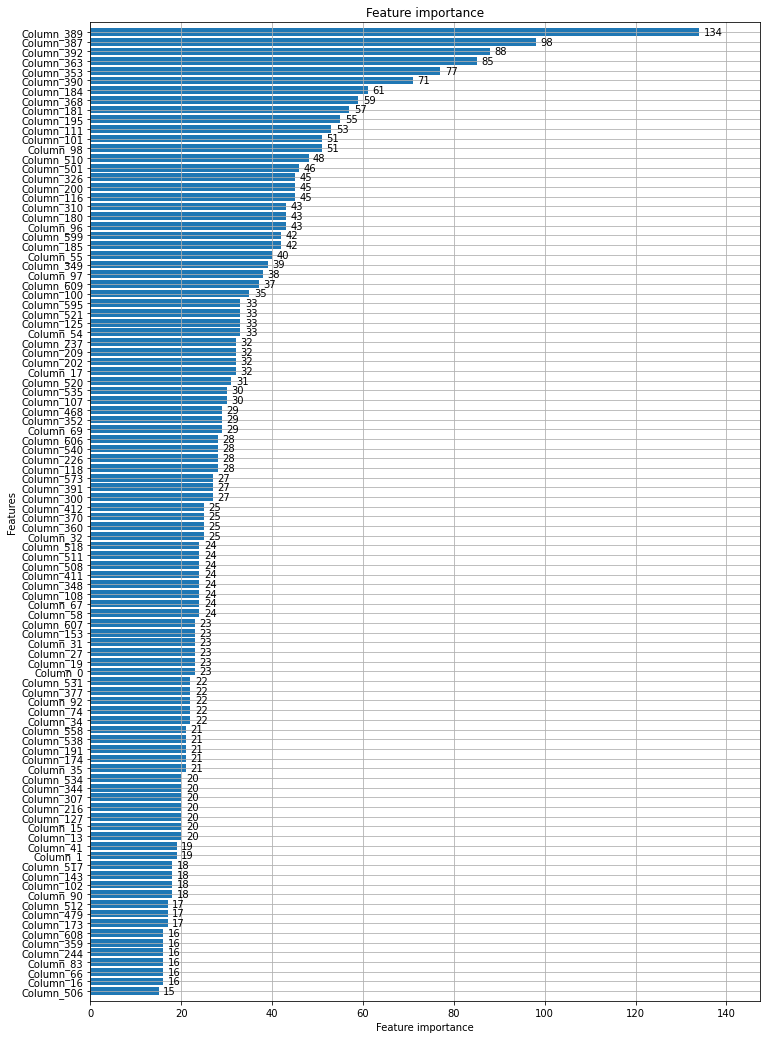

In [39]:
fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(models33, max_num_features=100, height=0.8, ax=ax)
plt.show()

In [47]:
models =model_kaggle(train_xx,label,feature_name_lst)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827712
[200]	valid's auc: 0.832016
[300]	valid's auc: 0.833699
Early stopping, best iteration is:
[301]	valid's auc: 0.833771
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827896
[200]	valid's auc: 0.83025
[300]	valid's auc: 0.830538
Early stopping, best iteration is:
[305]	valid's auc: 0.830603
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829631
[200]	valid's auc: 0.832858
[300]	valid's auc: 0.833084
Early stopping, best iteration is:
[224]	valid's auc: 0.833549
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831568
[200]	valid's auc: 0.834587
[300]	valid's auc: 0.834815
[400]	valid's auc: 0.835322
Early stopping, best iteration is:
[363]	valid's auc: 0.835605
Training until validation scores don't improve for 80 rounds
[100]	valid's auc

[200]	valid's auc: 0.82431
[300]	valid's auc: 0.825634
[400]	valid's auc: 0.826743
[500]	valid's auc: 0.827681
[600]	valid's auc: 0.827709
Early stopping, best iteration is:
[547]	valid's auc: 0.828271
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822739
[200]	valid's auc: 0.826238
[300]	valid's auc: 0.827043
Early stopping, best iteration is:
[316]	valid's auc: 0.827279
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821825
[200]	valid's auc: 0.825539
[300]	valid's auc: 0.826838
[400]	valid's auc: 0.827107
Early stopping, best iteration is:
[348]	valid's auc: 0.827619
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834379
[200]	valid's auc: 0.836113
[300]	valid's auc: 0.835505
Early stopping, best iteration is:
[262]	valid's auc: 0.836793
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832822
[200]	valid's auc: 0.833722
Early stopping, best iteratio

[100]	valid's auc: 0.831857
[200]	valid's auc: 0.832798
Early stopping, best iteration is:
[188]	valid's auc: 0.833055
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832263
[200]	valid's auc: 0.834153
Early stopping, best iteration is:
[163]	valid's auc: 0.834252
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833187
[200]	valid's auc: 0.832328
Early stopping, best iteration is:
[131]	valid's auc: 0.833364
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831913
Early stopping, best iteration is:
[109]	valid's auc: 0.83245
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until vali

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830498
[200]	valid's auc: 0.832588
Early stopping, best iteration is:
[206]	valid's auc: 0.833059
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828731
[200]	valid's auc: 0.828755
Early stopping, best iteration is:
[175]	valid's auc: 0.829167
Training until validation scores don't improve for 80 r

Early stopping, best iteration is:
[206]	valid's auc: 0.838512
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833787
[200]	valid's auc: 0.834231
Early stopping, best iteration is:
[168]	valid's auc: 0.834934
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836841
[200]	valid's auc: 0.837281
Early stopping, best iteration is:
[175]	valid's auc: 0.838024
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.81889
Early stopping, best iteration is:
[91]	valid's auc: 0.818906
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819615
Early stopping, best iteration is:
[95]	valid's auc: 0.81963
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819349
Early stopping, best iteration is:
[102]	valid's auc: 0.819433
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826794
[200]	valid's auc: 0.830005
[300]	va

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821626
Early stopping, best iteration is:
[106]	valid's auc: 0.821795
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820825
Early stopping, best iteration is:
[97]	valid's auc: 0.820838
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827136
[200]	valid's auc: 0.829884
[300]	valid's auc: 0.830527
[400]	valid's auc: 0.831582
[500]	valid's auc: 0.830661
Early stopping, best iteration is:
[422]	valid's auc: 0.831747
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831219
[200]	valid's auc: 0.831657
Early stopping, best iteration is:
[135]	valid's auc: 0.83301
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832354
Early stopping, best iteration is:
[98]	valid's auc: 0.83241
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832225
Early stopping, best iteration is:
[105]	valid's auc: 0.832746
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830041
[200]	valid's auc: 0.83038
Early stopping, best iteration is:
[150]	valid's auc

In [57]:
%%time
models2,pt =model_kaggle(train_xx,label,feature_name_lst,314)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82978
[200]	valid's auc: 0.834456
[300]	valid's auc: 0.835534
[400]	valid's auc: 0.835444
Early stopping, best iteration is:
[351]	valid's auc: 0.835775
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827276
[200]	valid's auc: 0.829856
[300]	valid's auc: 0.830009
Early stopping, best iteration is:
[278]	valid's auc: 0.830484
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829653
[200]	valid's auc: 0.832363
[300]	valid's auc: 0.833377
[400]	valid's auc: 0.833601
Early stopping, best iteration is:
[373]	valid's auc: 0.833711
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830976
[200]	valid's auc: 0.835233
[300]	valid's auc: 0.836102
Early stopping, best iteration is:
[282]	valid's auc: 0.836319
Training until validation scores don't improve for

[200]	valid's auc: 0.825423
[300]	valid's auc: 0.827443
[400]	valid's auc: 0.829006
[500]	valid's auc: 0.829302
[600]	valid's auc: 0.829454
Early stopping, best iteration is:
[535]	valid's auc: 0.829761
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.823897
[200]	valid's auc: 0.82789
[300]	valid's auc: 0.828894
Early stopping, best iteration is:
[319]	valid's auc: 0.829327
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822659
[200]	valid's auc: 0.827789
[300]	valid's auc: 0.828635
[400]	valid's auc: 0.828479
Early stopping, best iteration is:
[361]	valid's auc: 0.828974
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835359
[200]	valid's auc: 0.835167
Early stopping, best iteration is:
[130]	valid's auc: 0.836629
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833685
[200]	valid's auc: 0.833807
Early stopping, best iteration is:
[128]	valid's auc: 0.8

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829439
Early stopping, best iteration is:
[83]	valid's auc: 0.82974
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83011
[200]	valid's auc: 0.832936
[300]	valid's auc: 0.832763
Early stopping, best iteration is:
[222]	valid's auc: 0.833317
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830469
Early stopping, best iteration is:
[108]	valid's auc: 0.830472
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830054
[200]	valid's auc: 0.830716
Early stopping, best iteration is:
[153]	valid's auc: 0.831399
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, 

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830153
[200]	valid's auc: 0.83153
[300]	valid's auc: 0.831817
Early stopping, best iteration is:
[231]	valid's auc: 0.83258
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829039
[200]	valid's auc: 0.830067
Early stopping, best iteration is:
[202]	valid's auc: 0.830319
Training until validation sco

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833088
Early stopping, best iteration is:
[102]	valid's auc: 0.833407
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835407
[200]	valid's auc: 0.834874
Early stopping, best iteration is:
[133]	valid's auc: 0.836261
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834746
[200]	valid's auc: 0.834912
Early stopping, best iteration is:
[192]	valid's auc: 0.835162
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819134
Early stopping, best iteration is:
[102]	valid's auc: 0.819177
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819825
Early stopping, best iteration is:
[97]	valid's auc: 0.819878
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.81804
Early stopping, best iteration is:
[96]	valid's auc: 0.818043
Training until validation scores do

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822182
Early stopping, best iteration is:
[103]	valid's auc: 0.822348
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821936
Early stopping, best iteration is:
[106]	valid's auc: 0.822048
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.81957
Early stopping, best iteration is:
[104]	valid's auc: 0.819685
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826491
[200]	valid's auc: 0.828699
[300]	valid's auc: 0.829716
Early stopping, best iteration is:
[282]	valid's 

[100]	valid's auc: 0.826414
[200]	valid's auc: 0.828794
[300]	valid's auc: 0.829554
[400]	valid's auc: 0.829797
Early stopping, best iteration is:
[359]	valid's auc: 0.830004
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831363
[200]	valid's auc: 0.832955
Early stopping, best iteration is:
[186]	valid's auc: 0.833793
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830591
[200]	valid's auc: 0.831085
Early stopping, best iteration is:
[180]	valid's auc: 0.831761
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831303
[200]	valid's auc: 0.8325

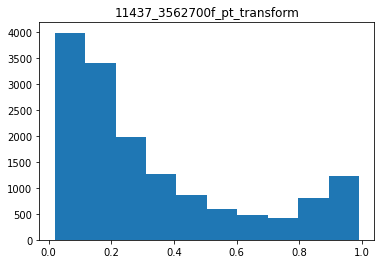

<Figure size 432x288 with 0 Axes>

In [61]:

name = str(datetime.datetime.now())[:-10]
name =name.replace("-","_").replace(" ","_").replace(":","_")
mode ='save'
model_name = '700f_pt_transform'

probabilities = models2.predict_proba(pt.transform(test_xx))
res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+model_name)
plt.hist(probabilities[:,1])
plt.show()
plt.savefig('../img/0121/result'+name+'.jpg')


if mode =='save':
    sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
    sample_submssion['problem'] = probabilities[:,1]
    save_name= name+model_name+".csv"
    sample_submssion.to_csv(SAVE_PATH+save_name, index = False)

else:
    nope




In [62]:
models3,pt2 =model_kaggle(train_xx,label,feature_name_lst,300)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827627
[200]	valid's auc: 0.83283
[300]	valid's auc: 0.834843
[400]	valid's auc: 0.835702
Early stopping, best iteration is:
[395]	valid's auc: 0.835854
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827219
[200]	valid's auc: 0.828482
[300]	valid's auc: 0.828106
Early stopping, best iteration is:
[258]	valid's auc: 0.828808
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829479
[200]	valid's auc: 0.832465
Early stopping, best iteration is:
[215]	valid's auc: 0.832882
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82995
[200]	valid's auc: 0.833102
[300]	valid's auc: 0.834157
Early stopping, best iteration is:
[271]	valid's auc: 0.834486
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828092
[200]	valid's auc:

[100]	valid's auc: 0.82274
[200]	valid's auc: 0.82525
[300]	valid's auc: 0.825388
[400]	valid's auc: 0.825672
Early stopping, best iteration is:
[320]	valid's auc: 0.826213
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820399
[200]	valid's auc: 0.825593
[300]	valid's auc: 0.826963
[400]	valid's auc: 0.827527
[500]	valid's auc: 0.827992
[600]	valid's auc: 0.827246
Early stopping, best iteration is:
[536]	valid's auc: 0.828113
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834514
[200]	valid's auc: 0.83773
Early stopping, best iteration is:
[193]	valid's auc: 0.837928
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834202
[200]	valid's auc: 0.834987
Early stopping, best iteration is:
[146]	valid's auc: 0.836428
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835137
[200]	valid's auc: 0.836191
Early stopping, best iteration is:
[189]	valid's auc: 0.836

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831174
[200]	valid's auc: 0.833772
Early stopping, best iteration is:
[176]	valid's auc: 0.833986
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830843
Early stopping, best iteration is:
[77]	valid's auc: 0.831671
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831388
[200]	valid's auc: 0.831909
Early stopping, best iteration is:
[161]	valid's auc: 0.832491
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.81477
[200]	valid's auc: 0.815122
Early stopping, best i

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830325
[200]	valid's auc: 0.832403
Early stopping, best iteration is:
[185]	valid's auc: 0.832851
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82839
[200]	valid's auc: 0.829704
[300]	valid's auc: 0.829748
Early stopping, best iteration is:
[249]	valid's auc: 0.830397
Training until validation sc

[200]	valid's auc: 0.829963
[300]	valid's auc: 0.830565
[400]	valid's auc: 0.830333
Early stopping, best iteration is:
[353]	valid's auc: 0.831407
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835064
[200]	valid's auc: 0.83624
Early stopping, best iteration is:
[139]	valid's auc: 0.837383
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83336
[200]	valid's auc: 0.834114
Early stopping, best iteration is:
[162]	valid's auc: 0.834803
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835483
[200]	valid's auc: 0.835391
Early stopping, best iteration is:
[174]	valid's auc: 0.836457
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819729
Early stopping, best iteration is:
[98]	valid's auc: 0.81973
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821087
Early stopping, best iteration is:
[102]	valid's auc: 0.821094
Training unti

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826475
[200]	valid's auc: 0.828754
[300]	valid's auc: 0.829276
Early stopping, best iteration is:
[299]	valid's auc: 0.829337
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821324
Early stopping, best iteration is:
[108]	valid's auc: 0.821532
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.823283
Early stopping, best iteration is:
[103]	valid's auc: 0.823324
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819662
Early stopping, best iteration is:
[94]	valid's auc: 0.819674
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	val

[200]	valid's auc: 0.83013
[300]	valid's auc: 0.830268
[400]	valid's auc: 0.830213
[500]	valid's auc: 0.830151
Early stopping, best iteration is:
[467]	valid's auc: 0.83065
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825482
[200]	valid's auc: 0.827074
[300]	valid's auc: 0.828002
Early stopping, best iteration is:
[289]	valid's auc: 0.828154
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.824962
[200]	valid's auc: 0.826857
[300]	valid's auc: 0.827462
Early stopping, best iteration is:
[277]	valid's auc: 0.827829
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds

In [63]:
models4,pt3 =model_kaggle(train_xx,label,feature_name_lst,1004)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82809
[200]	valid's auc: 0.83192
[300]	valid's auc: 0.834511
[400]	valid's auc: 0.833804
Early stopping, best iteration is:
[347]	valid's auc: 0.834776
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827619
[200]	valid's auc: 0.830527
Early stopping, best iteration is:
[195]	valid's auc: 0.830685
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828837
[200]	valid's auc: 0.831351
[300]	valid's auc: 0.831391
Early stopping, best iteration is:
[242]	valid's auc: 0.832025
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831493
[200]	valid's auc: 0.836107
[300]	valid's auc: 0.836814
[400]	valid's auc: 0.836974
Early stopping, best iteration is:
[336]	valid's auc: 0.837445
Training until validation scores don't improve for 80 rounds
[100]	valid's auc:

[100]	valid's auc: 0.823016
[200]	valid's auc: 0.82613
[300]	valid's auc: 0.826452
Early stopping, best iteration is:
[239]	valid's auc: 0.826677
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820385
[200]	valid's auc: 0.825013
[300]	valid's auc: 0.827012
[400]	valid's auc: 0.82689
Early stopping, best iteration is:
[373]	valid's auc: 0.827409
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835198
[200]	valid's auc: 0.835011
Early stopping, best iteration is:
[156]	valid's auc: 0.836314
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833484
[200]	valid's auc: 0.833322
Early stopping, best iteration is:
[121]	valid's auc: 0.835187
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832752
[200]	valid's auc: 0.835033
Early stopping, best iteration is:
[205]	valid's auc: 0.835538
Training until validation scores don't improve for 80 rounds
[100]	valid's auc:

[300]	valid's auc: 0.833226
Early stopping, best iteration is:
[230]	valid's auc: 0.834093
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83071
Early stopping, best iteration is:
[99]	valid's auc: 0.830726
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830381
Early stopping, best iteration is:
[117]	valid's auc: 0.831765
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.813128
[200]	valid's auc: 0.813256
Early stopping, best iteration is:
[155]	valid's auc: 0.813256
Training until validation scores don't improve for 80 rounds
[100]	valid's a

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83225
[200]	valid's auc: 0.832642
Early stopping, best iteration is:
[162]	valid's auc: 0.833781
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830458
[200]	valid's auc: 0.830908
Early stopping, best iteration is:
[153]	valid's auc: 0.831993
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83045
Early stopping, best iteration is:
[119]	valid's auc: 0.831686
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819802
Early stopping, best iteration is:
[102]	valid's a

[100]	valid's auc: 0.836238
[200]	valid's auc: 0.836492
Early stopping, best iteration is:
[164]	valid's auc: 0.836991
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832828
[200]	valid's auc: 0.833986
Early stopping, best iteration is:
[178]	valid's auc: 0.834896
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819596
[200]	valid's auc: 0.819613
Early stopping, best iteration is:
[161]	valid's auc: 0.819613
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820134
[200]	valid's auc: 0.820154
Early stopping, best iteration is:
[127]	valid's auc: 0.820154
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.817885
Early stopping, best iteration is:
[100]	valid's auc: 0.817885
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828392
[200]	valid's auc: 0.830566
[300]	valid's auc: 0.830256
Early stopping, best iteration is:
[241]	val

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82048
Early stopping, best iteration is:
[95]	valid's auc: 0.820514
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827013
[200]	valid's auc: 0.829473
[300]	valid's auc: 0.830481
[400]	valid's auc: 0.829939
Early stopping, best iteration is:
[348]	valid's auc: 0.831058
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828574
[200]	valid's auc: 0.829376
Early stopping, best iteration is:
[208]	valid's auc: 0.829541
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.8

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834434
Early stopping, best iteration is:
[105]	valid's auc: 0.834882
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831674
[200]	valid's auc: 0.829884
Early stopping, best iteration is:
[124]	valid's auc: 0.832
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828174
[200]	valid's auc: 0.829558
Early stopping, best iteration is:
[217]	valid's auc: 0.830068
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830068
[200]	valid's auc: 0.831606
[300]	valid's auc: 0.83

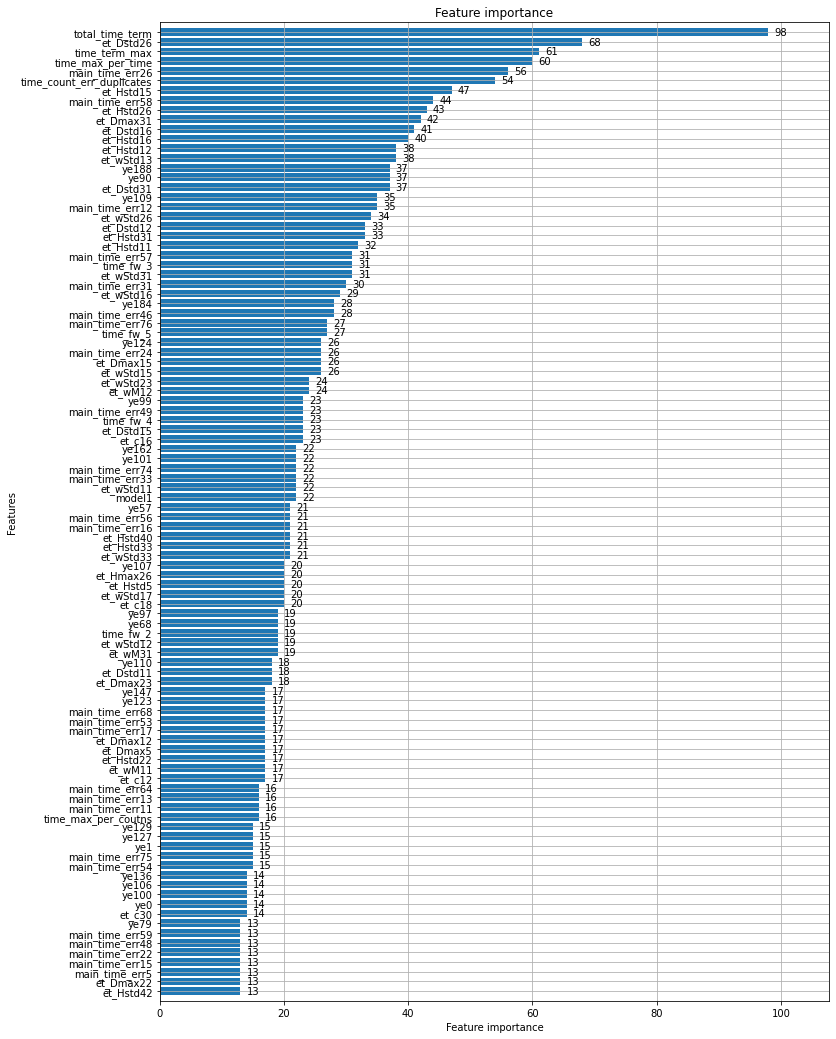

In [87]:
fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(models3, max_num_features=100, height=0.8, ax=ax)
plt.show()

In [76]:
probabilities1 = models2.predict_proba(pt.transform(test_xx))[:,1].reshape(-1,1)
probabilities2 = models3.predict_proba(pt2.transform(test_xx))[:,1].reshape(-1,1)
probabilities3 = models4.predict_proba(pt3.transform(test_xx))[:,1].reshape(-1,1)

In [77]:
tot =np.concatenate((probabilities1,probabilities2,probabilities3),axis=1)
tot

array([[0.96523937, 0.96929726, 0.94615186],
       [0.46627627, 0.37071958, 0.40206727],
       [0.42792276, 0.54596981, 0.51224448],
       ...,
       [0.69140288, 0.78063381, 0.68724838],
       [0.94025442, 0.95220976, 0.93010309],
       [0.24597514, 0.28251542, 0.27995866]])

In [78]:
totm = tot.mean(axis=1)

In [79]:
totm

array([0.9602295 , 0.41302104, 0.49537902, ..., 0.71976169, 0.94085576,
       0.26948307])

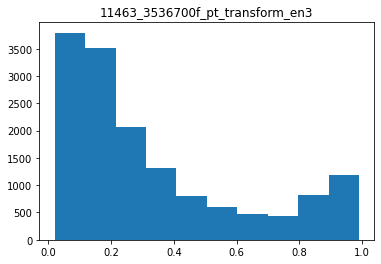

In [81]:
res =pd.DataFrame(np.where(totm>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+model_name)
plt.hist(totm)
plt.show()

In [80]:
model_name = '700f_pt_transform_en3'
sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
sample_submssion['problem'] = totm
save_name= name+model_name+".csv"
sample_submssion.to_csv(SAVE_PATH+save_name, index = False)

In [ ]:

name = str(datetime.datetime.now())[:-10]
name =name.replace("-","_").replace(" ","_").replace(":","_")
mode ='save'
model_name = '700f_pt_transform'

probabilities1 = models2.predict_proba(pt.transform(test_xx))
res =pd.DataFrame(np.where(probabilities1[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+model_name)
plt.hist(probabilities1[:,1])
plt.show()
plt.savefig('../img/0121/result'+name+'.jpg')


if mode =='save':
    sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
    sample_submssion['problem'] = probabilities1[:,1]
    save_name= name+model_name+".csv"
    sample_submssion.to_csv(SAVE_PATH+save_name, index = False)

else:
    nope




In [ ]:

name = str(datetime.datetime.now())[:-10]
name =name.replace("-","_").replace(" ","_").replace(":","_")
mode ='save'
model_name = '700f_pt_transform'

probabilities2 = models3.predict_proba(pt2.transform(test_xx))
res =pd.DataFrame(np.where(probabilities2[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+model_name)
plt.hist(probabilities2[:,1])
plt.show()
plt.savefig('../img/0121/result'+name+'.jpg')


if mode =='save':
    sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
    sample_submssion['problem'] = probabilities2[:,1]
    save_name= name+model_name+".csv"
    sample_submssion.to_csv(SAVE_PATH+save_name, index = False)

else:
    nope




In [ ]:
models2 =model_kaggle(train_xx,label,feature_name_lst)

In [ ]:
models3 =model_kaggle(train_xx,label,feature_name_lst)

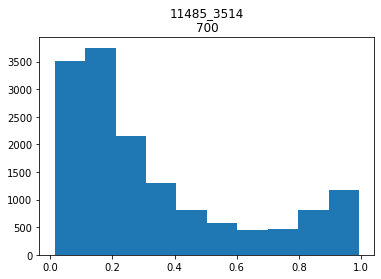

<Figure size 432x288 with 0 Axes>

In [52]:

name = str(datetime.datetime.now())[:-10]
name =name.replace("-","_").replace(" ","_").replace(":","_")
mode ='save'
model_name = '700f'

probabilities = models.predict_proba(test_xx)
res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'700')
plt.hist(probabilities[:,1])
plt.show()
plt.savefig('../img/0121/result'+name+'.jpg')


if mode =='save':
    sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
    sample_submssion['problem'] = probabilities[:,1]
    save_name= name+model_name+".csv"
    sample_submssion.to_csv(SAVE_PATH+save_name, index = False)

else:
    nope




# hyper parameter by kaggle https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761

In [810]:
train_yh =pd.read_csv('/Users/ds/Downloads/yhdata/train0127.csv').iloc[:,5:]
test_yh =pd.read_csv('/Users/ds/Downloads/yhdata/test0127.csv').iloc[:,5:]

In [811]:
train_yh.shape

(15000, 614)

In [812]:
#random seed base = 314
random_seed_change =314
from sklearn.model_selection import train_test_split
idxs = np.arange(15000)
X_train, X_test, y_train, y_test,idxs_train,idxs_tst = train_test_split(train_yh, train_y,idxs ,test_size=0.20, random_state=random_seed_change, stratify=train_y)

In [682]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
pt = PowerTransformer()
pt.fit(X_train)                       ## Fit the PT on training data
X_train = pt.transform(X_train)    ## Then apply on all data
X_test = pt.transform(X_test)

# X_val_pt = pt.transform(X_val)
## Here we are doing the same thing, but for the dependent variable 'SalePrice' exclusively
# pt_y = PowerTransformer()
# # PowerTransformer requires a matrix/DataFrame
# pt_y.fit(y_train)
 
# y_train_pt = pt_y.transform(y_train)
# y_test_pt = pt_y.transform(y_test)

In [813]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [814]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":80, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [815]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [816]:
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=random_seed_change,
    verbose=True)

In [817]:
#yh _614
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828958
[200]	valid's auc: 0.833576
[300]	valid's auc: 0.834318
Early stopping, best iteration is:
[279]	valid's auc: 0.834751
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827064
[200]	valid's auc: 0.829531
[300]	valid's auc: 0.829997
Early stopping, best iteration is:
[256]	valid's auc: 0.830489
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830265
[200]	valid's auc: 0.832842
[300]	valid's auc: 0.834001
Early stopping, best iteration is:
[297]	valid's auc: 0.834232
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830071
[200]	valid's auc: 0.834639
[300]	valid's auc: 0.835928
[400]	valid's auc: 0.836537
Early stopping, best iteration is:
[409]	valid's auc: 0.836784
Training until validation scores don't improve for 80 rounds
[100]	valid's au

[200]	valid's auc: 0.827384
[300]	valid's auc: 0.829302
[400]	valid's auc: 0.829771
[500]	valid's auc: 0.829343
Early stopping, best iteration is:
[428]	valid's auc: 0.82996
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822844
[200]	valid's auc: 0.826614
[300]	valid's auc: 0.826916
Early stopping, best iteration is:
[293]	valid's auc: 0.827198
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820767
[200]	valid's auc: 0.825005
[300]	valid's auc: 0.826719
[400]	valid's auc: 0.827287
Early stopping, best iteration is:
[385]	valid's auc: 0.82777
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833102
[200]	valid's auc: 0.836576
[300]	valid's auc: 0.836361
Early stopping, best iteration is:
[241]	valid's auc: 0.837444
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833704
[200]	valid's auc: 0.83461
Early stopping, best iteration is:
[215]	valid's auc: 0.835

[100]	valid's auc: 0.833319
[200]	valid's auc: 0.833572
Early stopping, best iteration is:
[160]	valid's auc: 0.835119
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833
[200]	valid's auc: 0.834658
[300]	valid's auc: 0.835024
Early stopping, best iteration is:
[243]	valid's auc: 0.83549
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83032
[200]	valid's auc: 0.830124
Early stopping, best iteration is:
[144]	valid's auc: 0.831031
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831878
[200]	valid's auc: 0.832847
Early stopping, best iteration is:
[129]	valid's auc: 0.833427
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best it

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831979
[200]	valid's auc: 0.834723
Early stopping, best iteration is:
[192]	valid's auc: 0.835333
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828758
[200]	valid's auc: 0.828986
Early stopping, best iteration is:
[156]	valid's auc: 0.830724
Training until validation scores don't improve for 80 r

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833996
[200]	valid's auc: 0.836938
Early stopping, best iteration is:
[185]	valid's auc: 0.837345
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835872
[200]	valid's auc: 0.836884
Early stopping, best iteration is:
[121]	valid's auc: 0.837698
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836058
[200]	valid's auc: 0.836291
Early stopping, best iteration is:
[147]	valid's auc: 0.837093
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819006
Early stopping, best iteration is:
[100]	valid's auc: 0.819006
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820693
Early stopping, best iteration is:
[100]	valid's auc: 0.820693
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.817506
Early stopping, best iteration is:
[93]	valid's auc: 0.817535
Train

Early stopping, best iteration is:
[105]	valid's auc: 0.820474
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822451
Early stopping, best iteration is:
[107]	valid's auc: 0.822526
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820006
Early stopping, best iteration is:
[88]	valid's auc: 0.820123
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828157
[200]	valid's auc: 0.830927
[300]	valid's auc: 0.832364
[400]	valid's auc: 0.831466
Early stopping, best iteration is:
[337]	valid's auc: 0.832654
Training until validation scores don't improve 

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833086
[200]	valid's auc: 0.834428
Early stopping, best iteration is:
[199]	valid's auc: 0.834473
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830239
[200]	valid's auc: 0.830136
Early stopping, best iteration is:
[132]	valid's auc: 0.830784
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834788
[200]	valid's auc: 0.834499
Early stopping, best iteration is:
[126]	valid's auc: 0.836415
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830923
[200]	valid's auc: 0.833162
[300]	valid's auc: 0.8338
[400]	valid's auc: 0.833205
Early stopping, best iteration is:
[375]	valid's auc: 0

In [781]:
#yh _619
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828025
[200]	valid's auc: 0.833317
[300]	valid's auc: 0.835175
Early stopping, best iteration is:
[289]	valid's auc: 0.835308
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828018
[200]	valid's auc: 0.830029
[300]	valid's auc: 0.830363
Early stopping, best iteration is:
[314]	valid's auc: 0.830692
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830315
[200]	valid's auc: 0.833457
Early stopping, best iteration is:
[199]	valid's auc: 0.833569
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831156
[200]	valid's auc: 0.835132
[300]	valid's auc: 0.836507
[400]	valid's auc: 0.836237
Early stopping, best iteration is:
[327]	valid's auc: 0.837148
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826597
[200]	valid's au

[400]	valid's auc: 0.82925
[500]	valid's auc: 0.829505
[600]	valid's auc: 0.829402
Early stopping, best iteration is:
[619]	valid's auc: 0.829841
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.823289
[200]	valid's auc: 0.826238
Early stopping, best iteration is:
[197]	valid's auc: 0.826244
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821684
[200]	valid's auc: 0.82705
[300]	valid's auc: 0.82881
[400]	valid's auc: 0.829044
Early stopping, best iteration is:
[368]	valid's auc: 0.829587
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835867
[200]	valid's auc: 0.837718
[300]	valid's auc: 0.837562
Early stopping, best iteration is:
[242]	valid's auc: 0.838684
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83265
[200]	valid's auc: 0.831413
Early stopping, best iteration is:
[122]	valid's auc: 0.833602
Training until validation scores don't improve for 80

Early stopping, best iteration is:
[183]	valid's auc: 0.832307
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831744
[200]	valid's auc: 0.833444
Early stopping, best iteration is:
[214]	valid's auc: 0.833799
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833441
[200]	valid's auc: 0.835846
[300]	valid's auc: 0.836014
Early stopping, best iteration is:
[256]	valid's auc: 0.83665
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829157
[200]	valid's auc: 0.829086
Early stopping, best iteration is:
[130]	valid's auc: 0.829725
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831609
[200]	valid's auc: 0.831261
Early stopping, best iteration is:
[121]	valid's auc: 0.832325
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stoppi

[200]	valid's auc: 0.829197
Early stopping, best iteration is:
[218]	valid's auc: 0.830137
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831108
[200]	valid's auc: 0.833306
[300]	valid's auc: 0.833433
Early stopping, best iteration is:
[227]	valid's auc: 0.834306

[400]	valid's auc: 0.832669
Early stopping, best iteration is:
[355]	valid's auc: 0.833207
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825349
[200]	valid's auc: 0.828578
[300]	valid's auc: 0.828444
Early stopping, best iteration is:
[253]	valid's auc: 0.828914
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826381
[200]	valid's auc: 0.829358
Early stopping, best iteration is:
[213]	valid's auc: 0.829578
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83605
[200]	valid's auc: 0.838379
[300]	valid's auc: 0.838812
Early stopping, best iteration is:
[290]	valid's auc: 0.839247
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836679
[200]	valid's auc: 0.836694
Early stopping, best iteration is:
[141]	valid's auc: 0.837692
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83646
[200]	valid's auc: 0.837192
Early stopping, be

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827819
[200]	valid's auc: 0.830403
[300]	valid's auc: 0.830473
Early stopping, best iteration is:
[287]	valid's auc: 0.830915
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82767
[200]	valid's auc: 0.830668
[300]	valid's auc: 0.831295
Early stopping, best iteration is:
[317]	valid's auc: 0.831985
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820826
Early stopping, best iteration is:
[101]	valid's auc: 0.820875
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822863
Early stopping, best iteration is:
[101]	valid's auc: 0.822868
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820088
Early stopping, best iteration is:
[90]	valid's auc: 0.820101
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training unti

[400]	valid's auc: 0.833252
[500]	valid's auc: 0.833857
[600]	valid's auc: 0.833904
Early stopping, best iteration is:
[523]	valid's auc: 0.834062
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826796
[200]	valid's auc: 0.829919
Early stopping, best iteration is:
[216]	valid's auc: 0.830179
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826988
[200]	valid's auc: 0.82971
[300]	valid's auc: 0.830499
Early stopping, best iteration is:
[235]	valid's auc: 0.831206
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833516
[200]	valid's auc: 0.83516

In [750]:
#random seed 314  , fw_time _611 remove [:5] 
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828272
[200]	valid's auc: 0.83236
[300]	valid's auc: 0.833469
[400]	valid's auc: 0.833368
Early stopping, best iteration is:
[339]	valid's auc: 0.834078
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828379
[200]	valid's auc: 0.831069
[300]	valid's auc: 0.83163
[400]	valid's auc: 0.831181
Early stopping, best iteration is:
[367]	valid's auc: 0.831731
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830049
[200]	valid's auc: 0.833167
[300]	valid's auc: 0.833295
Early stopping, best iteration is:
[278]	valid's auc: 0.833871
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831333
[200]	valid's auc: 0.834817
[300]	valid's auc: 0.836343
[400]	valid's auc: 0.837124
Early stopping, best iteration is:
[387]	valid's auc: 0.837189
Training until validati

[200]	valid's auc: 0.830146
[300]	valid's auc: 0.831266
[400]	valid's auc: 0.831175
Early stopping, best iteration is:
[341]	valid's auc: 0.831799
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82295
[200]	valid's auc: 0.827699
[300]	valid's auc: 0.828941
[400]	valid's auc: 0.829789
[500]	valid's auc: 0.830445
[600]	valid's auc: 0.830538
Early stopping, best iteration is:
[555]	valid's auc: 0.830859
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82323
[200]	valid's auc: 0.826892
[300]	valid's auc: 0.827692
[400]	valid's auc: 0.82812
Early stopping, best iteration is:
[409]	valid's auc: 0.828131
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822291
[200]	valid's auc: 0.826516
[300]	valid's auc: 0.828333
Early stopping, best iteration is:
[308]	valid's auc: 0.828467
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834792
[200]	valid's auc: 0.835098
[30

[100]	valid's auc: 0.829808
[200]	valid's auc: 0.829906
Early stopping, best iteration is:
[148]	valid's auc: 0.831404
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833894
[200]	valid's auc: 0.833577
Early stopping, best iteration is:
[154]	valid's auc: 0.83536
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83317
[200]	valid's auc: 0.835081
Early stopping, best iteration is:
[175]	valid's auc: 0.836383
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830543
[200]	valid's auc: 0.830014
Early stopping, best iteration is:
[126]	valid's auc: 0.831058
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832125
[200]	valid's auc: 0.83306
Early stopping, best iteration is:
[178]	valid's auc: 0.833444
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve 

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830908
[200]	valid's auc: 0.832271
[300]	valid's auc: 0.832925
Early stopping, best iteration is:
[240]	valid's auc: 0.834091
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829723
[

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826461
[200]	valid's auc: 0.827777
[300]	valid's auc: 0.82752
Early stopping, best iteration is:
[319]	valid's auc: 0.828392
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83485
[200]	valid's auc: 0.836757
[300]	valid's auc: 0.83635
Early stopping, best iteration is:
[236]	valid's auc: 0.837075
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833288
[200]	valid's auc: 0.834757
[300]	valid's auc: 0.834464
Early stopping, best iteration is:
[231]	valid's auc: 0.835469
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837481
Early stopping, best iteration is:
[103]	valid's auc: 0.837523
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.817794
Early stopping, best iteration is:
[97]	valid's auc: 0.817794
Training until validation scores don't improve for 80 rounds
[100]	valid's a

[200]	valid's auc: 0.829371
Early stopping, best iteration is:
[196]	valid's auc: 0.829716
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827881
[200]	valid's auc: 0.83016
[300]	valid's auc: 0.830528
Early stopping, best iteration is:
[238]	valid's auc: 0.831008
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821212
[200]	valid's auc: 0.821327
Early stopping, best iteration is:
[157]	valid's auc: 0.821327
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82352
Early stopping, best iteration is:
[91]	valid's auc: 0.823534
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819325
Early stopping, best iteration is:
[105]	valid's auc: 0.819349
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	val

[600]	valid's auc: 0.834094
Early stopping, best iteration is:
[562]	valid's auc: 0.834512
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825876
[200]	valid's auc: 0.828566
[300]	valid's auc: 0.829022
Early stopping, best iteration is:
[294]	valid's auc: 0.829272
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826206
[200]	valid's auc: 0.828817
[300]	valid's auc: 0.829886
[400]	valid's auc: 0.829686
Early stopping, best iteration is:
[371]	valid's auc: 0.830076
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82974
[200]	valid's auc: 0.83276

In [687]:
#random seed 314  , fw_time _610 remove [:4] + power transform
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830109
[200]	valid's auc: 0.83416
[300]	valid's auc: 0.83577
Early stopping, best iteration is:
[300]	valid's auc: 0.83577
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828293
[200]	valid's auc: 0.830904
[300]	valid's auc: 0.831197
Early stopping, best iteration is:
[234]	valid's auc: 0.831801
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828388
[200]	valid's auc: 0.830654
[300]	valid's auc: 0.831282
[400]	valid's auc: 0.831779
Early stopping, best iteration is:
[395]	valid's auc: 0.831856
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830364
[200]	valid's auc: 0.834362
[300]	valid's auc: 0.836002
[400]	valid's auc: 0.836021
Early stopping, best iteration is:
[343]	valid's auc: 0.83658
Training until validation scores don't improve for 80

[200]	valid's auc: 0.82677
[300]	valid's auc: 0.828727
[400]	valid's auc: 0.829484
[500]	valid's auc: 0.830282
Early stopping, best iteration is:
[470]	valid's auc: 0.830461
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821263
[200]	valid's auc: 0.82535
[300]	valid's auc: 0.825961
[400]	valid's auc: 0.826516
[500]	valid's auc: 0.826591
Early stopping, best iteration is:
[447]	valid's auc: 0.827142
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82252
[200]	valid's auc: 0.827373
[300]	valid's auc: 0.829556
[400]	valid's auc: 0.829659
[500]	valid's auc: 0.82953
Early stopping, best iteration is:
[467]	valid's auc: 0.830028
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835824
[200]	valid's auc: 0.837833
Early stopping, best iteration is:
[193]	valid's auc: 0.838271
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833238
[200]	valid's auc: 0.835163
Earl

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830423
[200]	valid's auc: 0.831421
Early stopping, best iteration is:
[179]	valid's auc: 0.831993
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831957
[200]	valid's auc: 0.832041
Early stopping, best iteration is:
[130]	valid's auc: 0.833051
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832935
[200]	valid's auc: 0.834268
Early stopping, best iteration is:
[135]	valid's auc: 0.834749
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830438
[200]	valid's auc: 0.830533
Early stopping, best iteration is:
[134]	valid's auc: 0.831364
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831996
[200]	valid's auc: 0.832356
[300]	valid's auc: 0.832907
Early stopping, best iteration is:
[258]	valid's auc: 0.833238
Training until validation scores don't improve for 80 rounds
Early stopp

[100]	valid's auc: 0.827258
[200]	valid's auc: 0.828013
Early stopping, best iteration is:
[190]	valid's auc: 0.828368
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826243
[200]	valid's auc: 0.829022
[300]	valid's auc: 0.829022
Early stopping, best iteration is:
[238]	valid's auc: 0.829605
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iterat

[200]	valid's auc: 0.830167
[300]	valid's auc: 0.83173
[400]	valid's auc: 0.832066
Early stopping, best iteration is:
[380]	valid's auc: 0.832418
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826539
[200]	valid's auc: 0.829551
[300]	valid's auc: 0.830237
[400]	valid's auc: 0.830944
Early stopping, best iteration is:
[383]	valid's auc: 0.831445
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825571
[200]	valid's auc: 0.828296
[300]	valid's auc: 0.828851
Early stopping, best iteration is:
[243]	valid's auc: 0.829398
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834619
[200]	valid's auc: 0.835802
Early stopping, best iteration is:
[210]	valid's auc: 0.835815
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834645
[200]	valid's auc: 0.835166
Early stopping, best iteration is:
[133]	valid's auc: 0.835996
Training until validation scores don't improve for

[200]	valid's auc: 0.832218
[300]	valid's auc: 0.832988
[400]	valid's auc: 0.833348
Early stopping, best iteration is:
[391]	valid's auc: 0.833458
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82751
[200]	valid's auc: 0.83116
[300]	valid's auc: 0.832464
[400]	valid's auc: 0.833412
Early stopping, best iteration is:
[397]	valid's auc: 0.833434
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826721
[200]	valid's auc: 0.828632
[300]	valid's auc: 0.828815
Early stopping, best iteration is:
[240]	valid's auc: 0.829144
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826786
[200]	valid's auc: 0.829836
Early stopping, best iteration is:
[210]	valid's auc: 0.830595
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822275
Early stopping, best iteration is:
[103]	valid's auc: 0.822384
Training until validation scores don't improve for 80 rounds
[100]	valid's auc:

[100]	valid's auc: 0.824651
[200]	valid's auc: 0.82747
[300]	valid's auc: 0.826774
Early stopping, best iteration is:
[268]	valid's auc: 0.827806
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.824241
[200]	valid's auc: 0.827554
[300]	valid's auc: 0.827882
Early stopping, best iteration is:
[284]	valid's auc: 0.828403
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826302
[200]	valid's auc: 0.829999
[300]	valid's auc: 0.83111
Early stopping, best iteration is:
[280]	valid's auc: 0.831464
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826472
[200]	valid's auc: 0.82918
[300]	valid's auc: 0.829426
[400]	valid's auc: 0.829445
Early stopping, best iteration is:
[332]	valid's auc: 0.830135
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825161
[200]	valid's auc: 0.82932
[300]	valid's auc: 0.829918
Early stopping, best iteration is:
[265]	valid's auc: 0.8301

In [653]:
#random seed 314  , fw_time _610 remove [:4]
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830068
[200]	valid's auc: 0.834314
[300]	valid's auc: 0.835897
Early stopping, best iteration is:
[314]	valid's auc: 0.836321
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827931
[200]	valid's auc: 0.830119
Early stopping, best iteration is:
[177]	valid's auc: 0.8306
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830798
[200]	valid's auc: 0.832692
Early stopping, best iteration is:
[179]	valid's auc: 0.832936
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830244
[200]	valid's auc: 0.836279
Early stopping, best iteration is:
[217]	valid's auc: 0.836735
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828537
[200]	valid's auc: 0.831744
[300]	valid's auc: 0.83221
Early stopping, best iteration is:
[294]	valid'

[200]	valid's auc: 0.825353
[300]	valid's auc: 0.827137
[400]	valid's auc: 0.828335
[500]	valid's auc: 0.829923
Early stopping, best iteration is:
[519]	valid's auc: 0.830141
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822162
[200]	valid's auc: 0.825654
[300]	valid's auc: 0.826465
Early stopping, best iteration is:
[299]	valid's auc: 0.826516
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822596
[200]	valid's auc: 0.827174
[300]	valid's auc: 0.828361
Early stopping, best iteration is:
[291]	valid's auc: 0.828508
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835538
[200]	valid's auc: 0.838566
Early stopping, best iteration is:
[203]	valid's auc: 0.838731
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833635
[200]	valid's auc: 0.8359
Early stopping, best iteration is:
[216]	valid's auc: 0.836464
Training until validation scores don't improve for 

[100]	valid's auc: 0.830831
[200]	valid's auc: 0.831891
Early stopping, best iteration is:
[174]	valid's auc: 0.832932
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832118
[200]	valid's auc: 0.834584
[300]	valid's auc: 0.835274
[400]	valid's auc: 0.835325
Early stopping, best iteration is:
[333]	valid's auc: 0.835474
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830697
[200]	valid's auc: 0.82945
Early stopping, best iteration is:
[144]	valid's auc: 0.831013
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83095
[200]	valid's auc: 0.831132
[300]	valid's auc: 0.83113
Early stopping, best iteration is:
[268]	valid's auc: 0.831883
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation 

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829381
[200]	valid's auc: 0.831761
Early stopping, best iteration is:
[196]	valid's auc: 0.831947
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828853
[200]	valid's auc: 0.828407
E

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825225
[200]	valid's auc: 0.827727
[300]	valid's auc: 0.827529
Early stopping, best iteration is:
[226]	valid's auc: 0.827933
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835079
[200]	valid's auc: 0.837408
Early stopping, best iteration is:
[211]	valid's auc: 0.837735
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834221
[200]	valid's auc: 0.835836
[300]	valid's auc: 0.834479
Early stopping, best iteration is:
[230]	valid's auc: 0.835982
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835143
[200]	valid's auc: 0.836078
Early stopping, best iteration is:
[135]	valid's auc: 0.8367
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820137
Early stopping, best iteration is:
[98]	valid's auc: 0.820149
Training until validation scores don't improve for 80 rounds
[100]	valid's 

[200]	valid's auc: 0.82933
[300]	valid's auc: 0.830616
Early stopping, best iteration is:
[304]	valid's auc: 0.830916
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827971
[200]	valid's auc: 0.830774
[300]	valid's auc: 0.830373
Early stopping, best iteration is:
[224]	valid's auc: 0.831364
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821565
Early stopping, best iteration is:
[102]	valid's auc: 0.821643
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822702
Early stopping, best iteration is:
[96]	valid's auc: 0.822704
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820523
Early stopping, best iteration is:
[93]	valid's auc: 0.820544
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	val

Early stopping, best iteration is:
[505]	valid's auc: 0.833102
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826322
[200]	valid's auc: 0.828102
[300]	valid's auc: 0.828773
[400]	valid's auc: 0.828702
Early stopping, best iteration is:
[338]	valid's auc: 0.829243
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826127
[200]	valid's auc: 0.829477
[300]	valid's auc: 0.830117
Early stopping, best iteration is:
[311]	valid's auc: 0.830355
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834156
[200]	valid's auc: 0.835612
Early stopping, best iter

In [613]:
#random seed 314  , fw_time
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828778
[200]	valid's auc: 0.832935
[300]	valid's auc: 0.834705
Early stopping, best iteration is:
[289]	valid's auc: 0.834878
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826918
[200]	valid's auc: 0.829155
[300]	valid's auc: 0.829505
[400]	valid's auc: 0.829916
Early stopping, best iteration is:
[331]	valid's auc: 0.830446
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830413
[200]	valid's auc: 0.832717
Early stopping, best iteration is:
[218]	valid's auc: 0.833344
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83139
[200]	valid's auc: 0.835952
[300]	valid's auc: 0.837538
Early stopping, best iteration is:
[286]	valid's auc: 0.837762
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828179
[200]	valid's auc

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.823533
[200]	valid's auc: 0.826206
[300]	valid's auc: 0.826523
Early stopping, best iteration is:
[235]	valid's auc: 0.826861
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820998
[200]	valid's auc: 0.826367
[300]	valid's auc: 0.827819
[400]	valid's auc: 0.828682
[500]	valid's auc: 0.828813
[600]	valid's auc: 0.829098
Early stopping, best iteration is:
[531]	valid's auc: 0.829363
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833867
[200]	valid's auc: 0.836805
[300]	valid's auc: 0.837611
Early stopping, best iteration is:
[246]	valid's auc: 0.838113
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83416
[200]	valid's auc: 0.834798
Early stopping, best iteration is:
[206]	valid's auc: 0.835163
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834071
[200]	valid's auc: 0.835

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832089
[200]	valid's auc: 0.833919
Early stopping, best iteration is:
[214]	valid's auc: 0.834752
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82933
Early stopping, best iteration is:
[112]	valid's auc: 0.829649
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832395
[200]	valid's auc: 0.832786
Early stopping, best iteration is:
[136]	valid's auc: 0.833595
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.813804
Early stopping, best iteration is:
[105]	valid's 

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830022
[200]	valid's auc: 0.831972
[300]	valid's auc: 0.831916
Early stopping, best iteration is:
[256]	valid's auc: 0.83295
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830591
[200]	valid's auc: 0.829364
Early stopping, best iteration is:
[129]	valid's auc: 0.831611
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831062
[200]	valid's auc: 0.833268
Early stopping, best iterati

[100]	valid's auc: 0.83648
[200]	valid's auc: 0.839713
Early stopping, best iteration is:
[177]	valid's auc: 0.840109
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834401
[200]	valid's auc: 0.8358
[300]	valid's auc: 0.834377
Early stopping, best iteration is:
[222]	valid's auc: 0.836076
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834342
[200]	valid's auc: 0.836599
Early stopping, best iteration is:
[180]	valid's auc: 0.836962
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819683
Early stopping, best iteration is:
[92]	valid's auc: 0.819729
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819966
Early stopping, best iteration is:
[103]	valid's auc: 0.820105
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.817363
Early stopping, best iteration is:
[93]	valid's auc: 0.817383
Training until validation scores don't imp

[100]	valid's auc: 0.82283
Early stopping, best iteration is:
[101]	valid's auc: 0.822864
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820614
Early stopping, best iteration is:
[93]	valid's auc: 0.820682
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827716
[200]	valid's auc: 0.831496
[300]	valid's auc: 0.833387
[400]	valid's auc: 0.834455
Early stopping, best iteration is:
[394]	valid's auc: 0.834697
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82787
[200]	valid's auc: 0.829484
Early stopping, best iteration is:
[197]	valid's auc: 0.

Early stopping, best iteration is:
[265]	valid's auc: 0.832676
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832974
[200]	valid's auc: 0.835543
Early stopping, best iteration is:
[162]	valid's auc: 0.836039
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831228
Early stopping, best iteration is:
[108]	valid's auc: 0.831633
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832895
[200]	valid's auc: 0.832044
Early stopping, best iteration is:
[139]	valid's auc: 0.833851
Training until validation scores don't improve for 80 rounds
[100]	valid's

In [599]:
#random seed 314  , fw_time
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828778
[200]	valid's auc: 0.832935
[300]	valid's auc: 0.834705
Early stopping, best iteration is:
[289]	valid's auc: 0.834878
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826918
[200]	valid's auc: 0.829155
[300]	valid's auc: 0.829505
[400]	valid's auc: 0.829916
Early stopping, best iteration is:
[331]	valid's auc: 0.830446
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830413
[200]	valid's auc: 0.832717
Early stopping, best iteration is:
[218]	valid's auc: 0.833344
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83139
[200]	valid's auc: 0.835952
[300]	valid's auc: 0.837538
Early stopping, best iteration is:
[286]	valid's auc: 0.837762
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828179
[200]	valid's auc

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.823533
[200]	valid's auc: 0.826206
[300]	valid's auc: 0.826523
Early stopping, best iteration is:
[235]	valid's auc: 0.826861
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820998
[200]	valid's auc: 0.826367
[300]	valid's auc: 0.827819
[400]	valid's auc: 0.828682
[500]	valid's auc: 0.828813
[600]	valid's auc: 0.829098
Early stopping, best iteration is:
[531]	valid's auc: 0.829363
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833867
[200]	valid's auc: 0.836805
[300]	valid's auc: 0.837611
Early stopping, best iteration is:
[246]	valid's auc: 0.838113
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83416
[200]	valid's auc: 0.834798
Early stopping, best iteration is:
[206]	valid's auc: 0.835163
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834071
[200]	valid's auc: 0.835

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832089
[200]	valid's auc: 0.833919
Early stopping, best iteration is:
[214]	valid's auc: 0.834752
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82933
Early stopping, best iteration is:
[112]	valid's auc: 0.829649
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832395
[200]	valid's auc: 0.832786
Early stopping, best iteration is:
[136]	valid's auc: 0.833595
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.813804
Early stopping, best iteration is:
[105]	valid's 

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830022
[200]	valid's auc: 0.831972
[300]	valid's auc: 0.831916
Early stopping, best iteration is:
[256]	valid's auc: 0.83295
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830591
[200]	valid's auc: 0.829364
Early stopping, best iteration is:
[129]	valid's auc: 0.831611
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831062
[200]	valid's auc: 0.833268
Early stopping, best iterati

[100]	valid's auc: 0.83648
[200]	valid's auc: 0.839713
Early stopping, best iteration is:
[177]	valid's auc: 0.840109
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834401
[200]	valid's auc: 0.8358
[300]	valid's auc: 0.834377
Early stopping, best iteration is:
[222]	valid's auc: 0.836076
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834342
[200]	valid's auc: 0.836599
Early stopping, best iteration is:
[180]	valid's auc: 0.836962
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819683
Early stopping, best iteration is:
[92]	valid's auc: 0.819729
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819966
Early stopping, best iteration is:
[103]	valid's auc: 0.820105
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.817363
Early stopping, best iteration is:
[93]	valid's auc: 0.817383
Training until validation scores don't imp

Early stopping, best iteration is:
[101]	valid's auc: 0.822864
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820614
Early stopping, best iteration is:
[93]	valid's auc: 0.820682
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827716
[200]	valid's auc: 0.831496
[300]	valid's auc: 0.833387
[400]	valid's auc: 0.834455
Early stopping, best iteration is:
[394]	valid's auc: 0.834697
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82787
[200]	valid's auc: 0.829484
Early stopping, best iteration is:
[197]	valid's auc: 0.829734
Training until valid

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832974
[200]	valid's auc: 0.835543
Early stopping, best iteration is:
[162]	valid's auc: 0.836039
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831228
Early stopping, best iteration is:
[108]	valid's auc: 0.831633
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832895
[200]	valid's auc: 0.832044
Early stopping, best iteration is:
[139]	valid's auc: 0.833851
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829221
[200]	valid's auc: 0.830924
Early stopping, best

In [521]:
#random seed 30
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820802
Early stopping, best iteration is:
[92]	valid's auc: 0.820866
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821759
Early stopping, best iteration is:
[85]	valid's auc: 0.821759
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821105
Early stopping, best iteration is:
[82]	valid's auc: 0.821137
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822457
Early stopping, best iteration is:
[93]	vali

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.809904
Early stopping, best iteration is:
[69]	valid's auc: 0.809904
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821198
Early stopping, best iteration is:
[88]	valid's auc: 0.821815
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825839
Early stopping, best iteration is:
[114]	valid's auc: 0.826395
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.823672
[200]	valid's auc: 0.82558
Early stopping, best iteration is:
[191]	valid's auc: 0.826111
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until v

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.810792
Early stopping, best iteration is:
[71]	valid's auc: 0.810792
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.809508
Early stopping, best iteration is:
[72]	valid's auc: 0.809509
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.824345
[200]	valid's auc: 0.824249
Early stopping, best iteration is:
[128]	valid's auc: 0.825223
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825271
Early stopping, best iteration is:
[71]	valid's auc: 0.825591
Training until v

Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825747
[200]	valid's auc: 0.825731
Early stopping, best iteration is:
[174]	valid's auc: 0.826327
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827862
[200]	valid's auc: 0.82808
Early stopping, best iteration is:
[181]	valid's auc: 0.828497
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825287
[200]	valid's auc: 0.82624
Early stopping, best iteration is:
[178]	valid's auc: 0.82704
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.809751
Early stopping, best iteration is:
[72]	valid's auc: 0.809789
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.812798
Early stopping, best iteration is:
[64]	valid's auc: 0.812798
Training until validation scores don't impro

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.828498
Early stopping, best iteration is:
[79]	valid's auc: 0.829491
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820566
Early stopping, best iteration is:
[90]	valid's auc: 0.820585
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821406
Early stopping, best iteration is:
[89]	valid's auc: 0.821406
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820748
Early stopping, best iteration is:
[85]	valid's auc: 0.820809
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.820864
Early stopping, best iteration is:
[51]	valid's auc: 0.822842
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825936
Early stopping, best iteration is:
[57]	valid's auc: 0.82775
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827825
Early 

[100]	valid's auc: 0.831673
Early stopping, best iteration is:
[92]	valid's auc: 0.832381
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829448
Early stopping, best iteration is:
[89]	valid's auc: 0.829747
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.809039
Early stopping, best iteration is:
[86]	valid's auc: 0.809061
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.810747
Early stopping, best iteration is:
[79]	valid's auc: 0.810747
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.809325
Early stopping, best iteration is:
[80]	valid's auc: 0.80934
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stoppi

In [362]:
#ye final (early 80 , connection err 4 include)
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829606
[200]	valid's auc: 0.833465
[300]	valid's auc: 0.83444
Early stopping, best iteration is:
[280]	valid's auc: 0.835057
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82928
[200]	valid's auc: 0.830897
[300]	valid's auc: 0.830873
Early stopping, best iteration is:
[254]	valid's auc: 0.831598
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830168
[200]	valid's auc: 0.832583
[300]	valid's auc: 0.832865
Early stopping, best iteration is:
[258]	valid's auc: 0.833409
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830825
[200]	valid's auc: 0.835166
[300]	valid's auc: 0.836665
[400]	valid's auc: 0.836915
Early stopping, best iteration is:
[394]	valid's auc: 0.837013
Training until validation scores don't improve for 80 rounds
[100]	valid's auc:

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822349
[200]	valid's auc: 0.826055
[300]	valid's auc: 0.82906
[400]	valid's auc: 0.829315
Early stopping, best iteration is:
[407]	valid's auc: 0.829463
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822609
[200]	valid's auc: 0.826318
[300]	valid's auc: 0.827001
Early stopping, best iteration is:
[259]	valid's auc: 0.827481
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82286
[200]	valid's auc: 0.827056
[300]	valid's auc: 0.829112
[400]	valid's auc: 0.829413
[500]	valid's auc: 0.830218
[600]	valid's auc: 0.830364
Early stopping, best iteration is:
[528]	valid's auc: 0.830732
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835194
[200]	valid's auc: 0.835553
Early stopping, best iteration is:
[130]	valid's auc: 0.836124
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.8346

[100]	valid's auc: 0.831618
[200]	valid's auc: 0.831886
Early stopping, best iteration is:
[199]	valid's auc: 0.83197
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831646
[200]	valid's auc: 0.832488
Early stopping, best iteration is:
[125]	valid's auc: 0.833284
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833605
[200]	valid's auc: 0.83602
[300]	valid's auc: 0.83473
Early stopping, best iteration is:
[220]	valid's auc: 0.836265
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830679
[200]	valid's auc: 0.83057
Early stopping, best iteration is:
[149]	valid's auc: 0.831272
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831783
[200]	valid's auc: 0.833178
[300]	valid's auc: 0.832632
Early stopping, best iteration is:
[223]	valid's auc: 0.833839
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's a

[100]	valid's auc: 0.827786
[200]	valid's auc: 0.828743
Early stopping, best iteration is:
[150]	valid's auc: 0.829526
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82971
[200]	valid's auc: 0.832171
[300]	valid's auc: 0.831659
Early stopping, best iteration is:


[200]	valid's auc: 0.827856
[300]	valid's auc: 0.82893
[400]	valid's auc: 0.829298
Early stopping, best iteration is:
[383]	valid's auc: 0.830159
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834283
[200]	valid's auc: 0.835442
Early stopping, best iteration is:
[209]	valid's auc: 0.836095
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837349
[200]	valid's auc: 0.837338
Early stopping, best iteration is:
[155]	valid's auc: 0.838628
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835445
Early stopping, best iteration is:
[117]	valid's auc: 0.836004
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.817852
Early stopping, best iteration is:
[87]	valid's auc: 0.81786
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819696
[200]	valid's auc: 0.819681
Early stopping, best iteration is:
[127]	valid's auc: 0.819697
Training unt

[400]	valid's auc: 0.829256
Early stopping, best iteration is:
[343]	valid's auc: 0.830143
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.821583
Early stopping, best iteration is:
[99]	valid's auc: 0.821644
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.822053
Early stopping, best iteration is:
[112]	valid's auc: 0.822064
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.819836
Early stopping, best iteration is:
[99]	valid's auc: 0.819847
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.829283
[200]	valid's a

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827943
[200]	valid's auc: 0.830744
[300]	valid's auc: 0.831534
Early stopping, best iteration is:
[295]	valid's auc: 0.831868
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831879
[200]	valid's auc: 0.833923
Early stopping, best iteration is:
[192]	valid's auc: 0.833994
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830607
Early stopping, best iteration is:
[113]	valid's auc: 0.831272
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831553
[200]	valid's auc: 0

In [819]:
opt_parameters = {'colsample_bytree': 0.8665631328558623, 'min_child_samples': 122, 'min_child_weight': 0.1, 'num_leaves': 48, 'reg_alpha': 2, 'reg_lambda': 50, 'subsample': 0.7252600946741159}

In [820]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)


 #yh 615
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


LGBMClassifier(colsample_bytree=0.8665631328558623, metric='None',
               min_child_samples=122, min_child_weight=0.1, n_estimators=5000,
               n_jobs=4, num_leaves=48, random_state=314, reg_alpha=2,
               reg_lambda=50, subsample=0.7252600946741159)

In [821]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [822]:
 #yh 615
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.839118
[200]	valid's auc: 0.839785
Early stopping, best iteration is:
[216]	valid's auc: 0.840005
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837919
[200]	valid's auc: 0.838675
Early stopping, best iteration is:
[179]	valid's auc: 0.839178
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837176
[200]	valid's auc: 0.837833
Early stopping, best iteration is:
[170]	valid's auc: 0.838696
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837043
[200]	valid's auc: 0.837679
Early stopping, best iteration is:
[164]	valid's auc: 0.838451
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837595
[200]	valid's auc: 0.839503
Early stopping, best iteration is:
[205]	valid's auc: 0.839619
Training until validation scores don't i

In [786]:
 #yh 619
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834907
[200]	valid's auc: 0.836343
Early stopping, best iteration is:
[204]	valid's auc: 0.836584
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.838854
[200]	valid's auc: 0.839241
Early stopping, best iteration is:
[175]	valid's auc: 0.839824
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836612
[200]	valid's auc: 0.837525
[300]	valid's auc: 0.83597
Early stopping, best iteration is:
[223]	valid's auc: 0.838377
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836611
[200]	valid's auc: 0.836936
Early stopping, best iteration is:
[206]	valid's auc: 0.837885
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836696
[200]	valid's auc: 0.837603
Early stopping, best iteration is:
[180]	valid's auc: 0.838482
Training unti

In [754]:
 #ye final +connection err4 +fw time +1 +remove first 5
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836444
Early stopping, best iteration is:
[112]	valid's auc: 0.837754
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837332
[200]	valid's auc: 0.838481
[300]	valid's auc: 0.837905
Early stopping, best iteration is:
[236]	valid's auc: 0.839214
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837181
[200]	valid's auc: 0.8393
Early stopping, best iteration is:
[184]	valid's auc: 0.83978
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837348
[200]	valid's auc: 0.838465
Early stopping, best iteration is:
[155]	valid's auc: 0.838603
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832995
[200]	valid's auc: 0.834999
Early stopping, best iteration is:
[191]	valid's auc: 0.835565
Training until validation scores don't impr

In [691]:
 #ye final +connection err4 +fw time +remove first 5 +power_trans_form
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835623
Early stopping, best iteration is:
[118]	valid's auc: 0.837177
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.838284
Early stopping, best iteration is:
[68]	valid's auc: 0.838464
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837656
Early stopping, best iteration is:
[97]	valid's auc: 0.838037
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836155
[200]	valid's auc: 0.836705
Early stopping, best iteration is:
[155]	valid's auc: 0.837762
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837494
Early stopping, best iteration is:
[98]	valid's auc: 0.837883
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835201
[200]	valid's auc: 0.833859
Early stopping, best iteration is:
[16

In [657]:
#ye final +connection err4 +fw time +remove first 5
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83641
[200]	valid's auc: 0.837013
Early stopping, best iteration is:
[143]	valid's auc: 0.838089
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837357
[200]	valid's auc: 0.838339
Early stopping, best iteration is:
[171]	valid's auc: 0.839003
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835846
[200]	valid's auc: 0.836988
[300]	valid's auc: 0.8377
Early stopping, best iteration is:
[311]	valid's auc: 0.838091
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835538
[200]	valid's auc: 0.836538
Early stopping, best iteration is:
[169]	valid's auc: 0.837099
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836355
Early stopping, best iteration is:
[117]	valid's auc: 0.83716
Training until validation scores don't impro

In [626]:
#ye final +connection err4 +fw time
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835773
Early stopping, best iteration is:
[117]	valid's auc: 0.83721
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835045
[200]	valid's auc: 0.836216
[300]	valid's auc: 0.835538
Early stopping, best iteration is:
[240]	valid's auc: 0.837041
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83342
[200]	valid's auc: 0.833543
Early stopping, best iteration is:
[157]	valid's auc: 0.83444
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831617
[200]	valid's auc: 0.834091
[300]	valid's auc: 0.834814
Early stopping, best iteration is:
[300]	valid's auc: 0.834814
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833267
[200]	valid's auc: 0.833669
Early stopping, best iteration is:
[162]	valid's auc: 0.833937
Training until 

In [603]:
#ye final +connection err4 +fw time
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835773
Early stopping, best iteration is:
[117]	valid's auc: 0.83721
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.835045
[200]	valid's auc: 0.836216
[300]	valid's auc: 0.835538
Early stopping, best iteration is:
[240]	valid's auc: 0.837041
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83342
[200]	valid's auc: 0.833543
Early stopping, best iteration is:
[157]	valid's auc: 0.83444
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.831617
[200]	valid's auc: 0.834091
[300]	valid's auc: 0.834814
Early stopping, best iteration is:
[300]	valid's auc: 0.834814
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833267
[200]	valid's auc: 0.833669
Early stopping, best iteration is:
[162]	valid's auc: 0.833937
Training until 

In [525]:
#ye final +connection err4
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.825288
Early stopping, best iteration is:
[73]	valid's auc: 0.825879
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83026
[200]	valid's auc: 0.829609
Early stopping, best iteration is:
[145]	valid's auc: 0.83194
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.830802
[200]	valid's auc: 0.830357
Early stopping, best iteration is:
[165]	valid's auc: 0.831763
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.827847
Early stopping, best iteration is:
[107]	valid's auc: 0.828125
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.82972
[200]	valid's auc: 0.829211
Early stopping, best iteration is:
[150]	valid's auc: 0.830276
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.826516
Early stopp

In [318]:
#ye final
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.837089
Early stopping, best iteration is:
[84]	valid's auc: 0.837986
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83929
Early stopping, best iteration is:
[88]	valid's auc: 0.839909
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.839777
Early stopping, best iteration is:
[84]	valid's auc: 0.84087
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.840361
[200]	valid's auc: 0.839584
Early stopping, best iteration is:
[127]	valid's auc: 0.840731
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836836
Early stopping, best iteration is:
[87]	valid's auc: 0.837835
Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.834317
Early stopping, best iteration is:
[73]	valid's auc: 0.836126
Trainin

ye_max

In [319]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.840701
[200]	valid's auc: 0.841954
[300]	valid's auc: 0.842044
Early stopping, best iteration is:
[263]	valid's auc: 0.842399


LGBMClassifier(colsample_bytree=0.55607546409401, metric='None',
               min_child_samples=103, min_child_weight=10.0, n_estimators=5000,
               n_jobs=4, num_leaves=22, random_state=314, reg_alpha=2,
               reg_lambda=1, subsample=0.8939112927620336)

seed 30

In [526]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.832296
[200]	valid's auc: 0.832875
[300]	valid's auc: 0.832867
Early stopping, best iteration is:
[250]	valid's auc: 0.833201


LGBMClassifier(colsample_bytree=0.4571436620780188, metric='None',
               min_child_samples=108, min_child_weight=10.0, n_estimators=5000,
               n_jobs=4, num_leaves=24, random_state=314, reg_alpha=0.1,
               reg_lambda=50, subsample=0.531672742732757)

In [627]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.833567
[200]	valid's auc: 0.836375
[300]	valid's auc: 0.836696
[400]	valid's auc: 0.837368
[500]	valid's auc: 0.837482
Early stopping, best iteration is:
[472]	valid's auc: 0.837548


LGBMClassifier(colsample_bytree=0.6879091728281055, metric='None',
               min_child_samples=163, min_child_weight=10.0, n_estimators=5000,
               n_jobs=4, num_leaves=10, random_state=314, reg_alpha=1,
               reg_lambda=0.1, subsample=0.6775057521029393)

In [660]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.836534
[200]	valid's auc: 0.838268
[300]	valid's auc: 0.839186
[400]	valid's auc: 0.839442
Early stopping, best iteration is:
[374]	valid's auc: 0.839539


LGBMClassifier(colsample_bytree=0.7173613575636579, metric='None',
               min_child_samples=134, min_child_weight=1e-05, n_estimators=5000,
               n_jobs=4, num_leaves=14, random_state=314, reg_alpha=0,
               reg_lambda=20, subsample=0.5813098915332424)

In [693]:
# 610 + power trans form
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.840812
[200]	valid's auc: 0.841445
Early stopping, best iteration is:
[141]	valid's auc: 0.842041


LGBMClassifier(colsample_bytree=0.55607546409401, metric='None',
               min_child_samples=103, min_child_weight=10.0, n_estimators=5000,
               n_jobs=4, num_leaves=22, random_state=314, reg_alpha=2,
               reg_lambda=1, subsample=0.8939112927620336)

In [755]:
# 610 + power trans form
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.838287
[200]	valid's auc: 0.84052
[300]	valid's auc: 0.841124
[400]	valid's auc: 0.841294
[500]	valid's auc: 0.841441
[600]	valid's auc: 0.841514
[700]	valid's auc: 0.841506
Early stopping, best iteration is:
[634]	valid's auc: 0.841549


LGBMClassifier(colsample_bytree=0.7173613575636579, metric='None',
               min_child_samples=134, min_child_weight=1e-05, n_estimators=5000,
               n_jobs=4, num_leaves=14, random_state=314, reg_alpha=0,
               reg_lambda=20, subsample=0.5813098915332424)

In [800]:
#yh619

#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst)

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83599
[200]	valid's auc: 0.838089
[300]	valid's auc: 0.838767
Early stopping, best iteration is:
[304]	valid's auc: 0.838833


LGBMClassifier(colsample_bytree=0.7173613575636579, metric='None',
               min_child_samples=134, min_child_weight=1e-05, n_estimators=5000,
               n_jobs=4, num_leaves=14, random_state=314, reg_alpha=0,
               reg_lambda=20, subsample=0.5813098915332424)

In [824]:
#yh615

#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],feature_name =feature_name_lst[5:])

Training until validation scores don't improve for 80 rounds
[100]	valid's auc: 0.83883
[200]	valid's auc: 0.840527
[300]	valid's auc: 0.84143
[400]	valid's auc: 0.841719
[500]	valid's auc: 0.841943
Early stopping, best iteration is:
[460]	valid's auc: 0.842004


LGBMClassifier(colsample_bytree=0.8665631328558623, metric='None',
               min_child_samples=122, min_child_weight=0.1, n_estimators=5000,
               n_jobs=4, num_leaves=48, random_state=314, reg_alpha=2,
               reg_lambda=50, subsample=0.7252600946741159)

In [670]:
pd.DataFrame(train_xxx).to_csv(SAVE_PATH+"/train0126_feaeture_615.csv")
pd.DataFrame(test_xxx).to_csv(SAVE_PATH+"/test0126_feaeture_615.csv")

In [756]:
probabilities = clf_final.predict_proba(pd.DataFrame(test_xxx).iloc[:,5:].values)
name = str(datetime.datetime.now())[:-10] +"_fw_time_5_610f_remove_5"

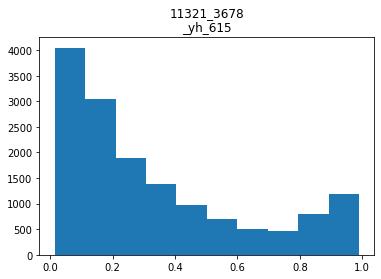

<Figure size 432x288 with 0 Axes>

In [826]:
probabilities = clf_final.predict_proba(test_yh)
name = str(datetime.datetime.now())[:-10] +"_yh_615"

res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'_yh_615')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

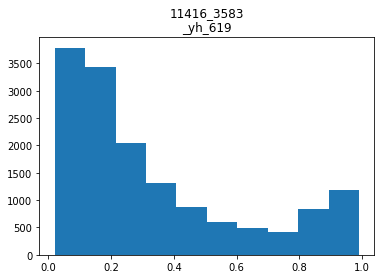

<Figure size 432x288 with 0 Axes>

In [803]:
probabilities = clf_final.predict_proba(test_yh)
name = str(datetime.datetime.now())[:-10] +"_yh_619"

res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'_yh_619')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

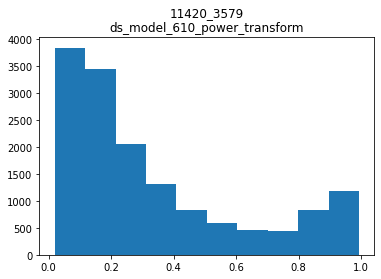

<Figure size 432x288 with 0 Axes>

In [757]:
probabilities = clf_final.predict_proba(pd.DataFrame(test_xxx).iloc[:,5:].values)
name = str(datetime.datetime.now())[:-10] +"_fw_time_5_610f_remove_5"

res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'ds_model_610_power_transform')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

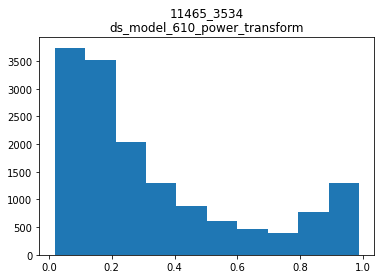

<Figure size 432x288 with 0 Axes>

In [714]:
test_xxx_trans = pt.transform(pd.DataFrame(test_xxx).iloc[:,5:].values)
probabilities = clf_final.predict_proba(test_xxx_trans)
name = str(datetime.datetime.now())[:-10] +"_fw_time_5_610f_remove_5"

res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'ds_model_610_power_transform')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

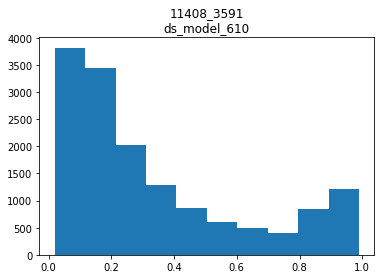

<Figure size 432x288 with 0 Axes>

In [667]:
res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'ds_model_610')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

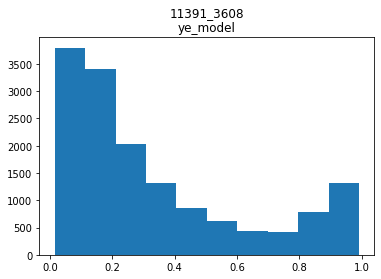

<Figure size 432x288 with 0 Axes>

In [369]:
res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'ye_model')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

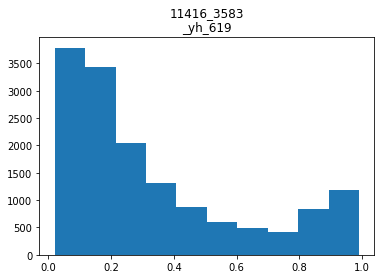

<Figure size 432x288 with 0 Axes>

In [804]:
probabilities = clf_final.predict_proba(test_yh)
name = str(datetime.datetime.now())[:-10] +"_yh_619"

res =pd.DataFrame(np.where(probabilities[:,1]>0.5,1,0)).value_counts().values
plt.title(str(res[0])+"_"+str(res[1])+"\n"+'_yh_619')
plt.hist(probabilities[:,1])
plt.show()

plt.savefig('../img/0121/result'+name+'.jpg')

In [827]:

sample_submssion = pd.read_csv(DATA_PATH+'sample_submission.csv')
sample_submssion['problem'] = probabilities[:,1]
save_name= name+"_fwtime_%s_%s_yh615"%(seed1,seed2)+".csv"
sample_submssion.to_csv(SAVE_PATH+save_name, index = False)


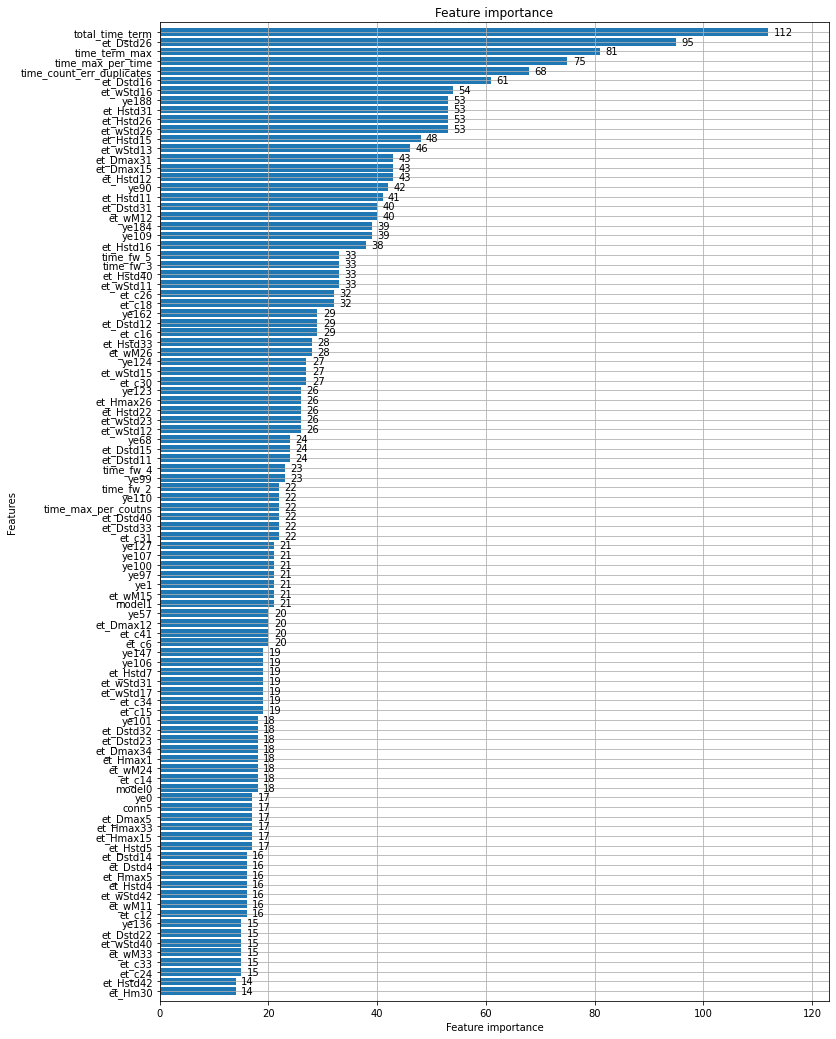

In [805]:
fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(clf_final, max_num_features=100, height=0.8, ax=ax)
plt.show()

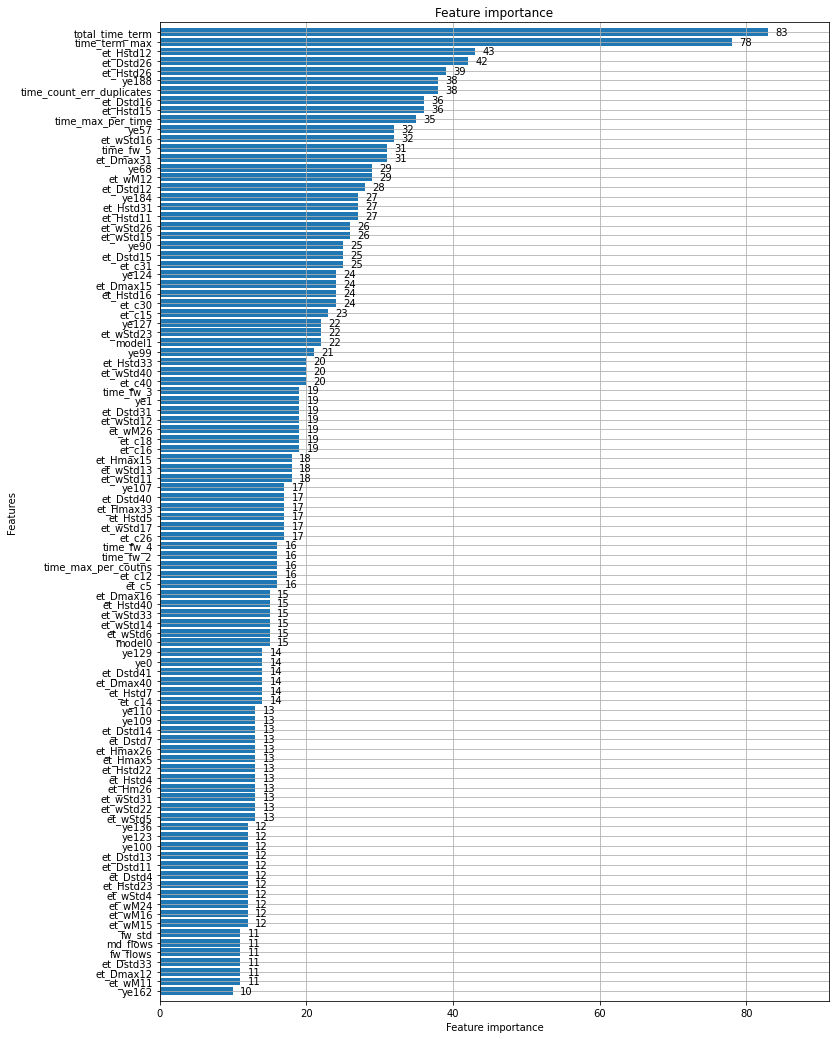

In [712]:
fig, ax = plt.subplots(figsize=(12,18))

lgb.plot_importance(clf_final, max_num_features=100, height=0.8, ax=ax)
plt.show()

In [715]:
a =sorted(idxs_tst+10000)

dd=tre.loc[tre.user_id.isin(a)]
ddd=dd[['user_id','count_e']].drop_duplicates().count_e
pd.DataFrame(np.where(ddd>0,1,0)).value_counts()

0    2000
1    1000
dtype: int64

In [717]:
p=clf_final.predict_proba(X_test)[:,1]

In [718]:
clre = pd.DataFrame([idxs_tst,p]).T

In [719]:
clre[0] +=10000

In [720]:
red=clre.sort_values(0).reset_index(drop=True).rename(columns={0:'user_id',1:'prob'})
red.user_id =red.user_id.astype('int')
red

,user_id,prob
0,10026,0.055969
1,10028,0.086077
2,10032,0.635282
3,10034,0.076021
4,10035,0.146632
...,...,...
2995,24961,0.100211
2996,24967,0.907843
2997,24970,0.036397
2998,24981,0.458624


In [721]:
test =tre.loc[tre.user_id.isin(red.user_id)].reset_index(drop=True)
test_total = pd.merge(test,red)

In [722]:
test_prob_Re = test_total[['user_id','count_e','prob']].drop_duplicates()
test_prob_Re['true'] = np.where(test_prob_Re['count_e']>0,1,0)
test_prob_Re['prob_true'] = np.where(test_prob_Re['prob']>0.5,1,0)

In [723]:
print('accuracy : ',(len(test_prob_Re.loc[test_prob_Re.prob_true ==test_prob_Re.true])/len(test_prob_Re))*100)

accuracy :  80.63333333333334


In [724]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_prob_Re['true'], test_prob_Re['prob'], pos_label=1)
metrics.auc(fpr, tpr)

                                                                            

0.8420414999999999

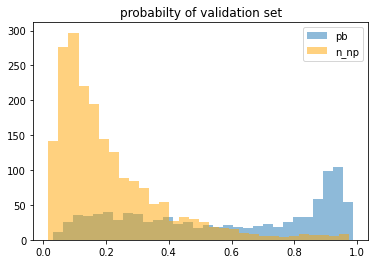

In [725]:
plt.hist(test_prob_Re.loc[test_prob_Re.true ==1].prob,bins=30,label='pb',alpha=0.5)
plt.hist(test_prob_Re.loc[test_prob_Re.true ==0].prob,bins=30,label='n_np',alpha=0.5,color='orange')
plt.legend()
plt.title('probabilty of validation set')
plt.show()

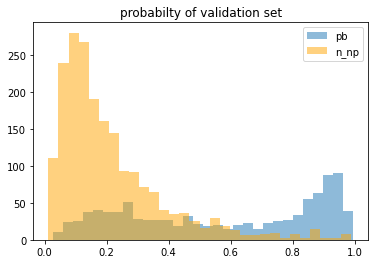

In [644]:
plt.hist(test_prob_Re.loc[test_prob_Re.true ==1].prob,bins=30,label='pb',alpha=0.5)
plt.hist(test_prob_Re.loc[test_prob_Re.true ==0].prob,bins=30,label='n_np',alpha=0.5,color='orange')
plt.legend()
plt.title('probabilty of validation set')
plt.show()

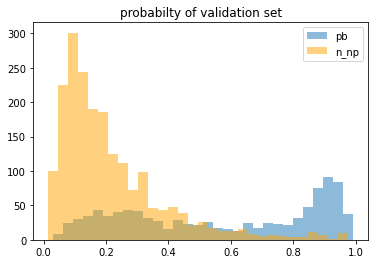

In [511]:
plt.hist(test_prob_Re.loc[test_prob_Re.true ==1].prob,bins=30,label='pb',alpha=0.5)
plt.hist(test_prob_Re.loc[test_prob_Re.true ==0].prob,bins=30,label='n_np',alpha=0.5,color='orange')
plt.legend()
plt.title('probabilty of validation set')
plt.show()

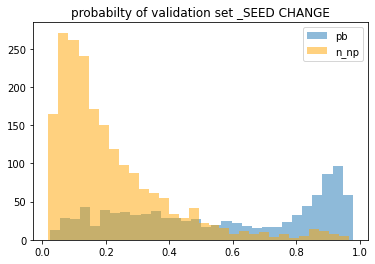

In [541]:
plt.hist(test_prob_Re.loc[test_prob_Re.true ==1].prob,bins=30,label='pb',alpha=0.5)
plt.hist(test_prob_Re.loc[test_prob_Re.true ==0].prob,bins=30,label='n_np',alpha=0.5,color='orange')
plt.legend()
plt.title('probabilty of validation set _SEED CHANGE')
plt.show()

In [727]:
t1=test[['user_id','fwver']].drop_duplicates().fwver.value_counts().to_frame().reset_index().rename(columns={'fwver':'total_counts','index':'fwver'})
t1

,fwver,total_counts
0,04.33.1261,901
1,04.22.1750,846
2,04.22.1778,819
3,04.33.1185,669
4,05.15.2138,638
5,04.16.3553,565
6,03.11.1167,141
7,04.16.3571,110
8,04.33.1149,24
9,05.66.3237,17


In [731]:
t2=tre.loc[tre.user_id.isin(test_prob_Re.loc[(test_prob_Re.prob <0.5)&(test_prob_Re.true ==1)].user_id)][['user_id','fwver']].drop_duplicates().fwver.value_counts().to_frame().reset_index().rename(columns={'fwver':'problem_guess','index':'fwver'})
t2

,fwver,problem_guess
0,04.22.1750,117
1,04.33.1261,117
2,04.22.1778,115
3,04.33.1185,102
4,05.15.2138,85
5,04.16.3553,74
6,03.11.1167,24
7,04.16.3571,9
8,05.66.3237,7
9,04.22.1684,4


In [733]:
t3=pd.merge(t1,t2,how='outer')
t3['ratio']=t3['problem_guess']/t3['total_counts']*100

In [734]:
t3

,fwver,total_counts,problem_guess,ratio
0,04.33.1261,901,117.0,12.985572
1,04.22.1750,846,117.0,13.829787
2,04.22.1778,819,115.0,14.041514
3,04.33.1185,669,102.0,15.246637
4,05.15.2138,638,85.0,13.322884
5,04.16.3553,565,74.0,13.097345
6,03.11.1167,141,24.0,17.021277
7,04.16.3571,110,9.0,8.181818
8,04.33.1149,24,NaN,NaN
9,05.66.3237,17,7.0,41.176471


In [562]:
test_prob_Re.to_csv("/Users/ds/Documents/data/result/get_validation.csv",index=0)

In [569]:
tre.loc[tre.user_id==15208].tail(30)

,user_id,time,model_nm,fwver,errtype,errcode,count_e,model_f,ver_num,week
5582215,15208,2020-11-18 17:13:28,model_3,05.15.2138,14,1,1,3,39,47
5582216,15208,2020-11-20 02:06:01,model_3,05.15.2138,11,1,1,3,39,47
5582217,15208,2020-11-20 02:06:01,model_3,05.15.2138,12,1,1,3,39,47
5582218,15208,2020-11-20 02:06:09,model_3,05.15.2138,5,Q-64002,1,3,39,47
5582219,15208,2020-11-22 02:06:01,model_3,05.15.2138,11,1,1,3,39,47
5582220,15208,2020-11-22 02:06:01,model_3,05.15.2138,12,1,1,3,39,47
5582221,15208,2020-11-24 02:06:01,model_3,05.15.2138,12,1,1,3,39,48
5582222,15208,2020-11-24 02:06:01,model_3,05.15.2138,11,1,1,3,39,48
5582223,15208,2020-11-26 02:05:49,model_3,05.15.2138,4,0,1,3,39,48
5582224,15208,2020-11-26 02:06:01,model_3,05.15.2138,12,1,1,3,39,48


In [573]:
len(tre.loc[tre.fwver =='05.15.2138'].user_id.unique())

3099

In [576]:
pd.DataFrame(np.where(tre.loc[tre.fwver =='05.15.2138'][['user_id','count_e']].drop_duplicates()['count_e'].values>0,1,0)).value_counts()

0    2379
1     720
dtype: int64

In [581]:
pd.DataFrame(np.where(tre.loc[(tre.fwver =='05.15.2138') &(tre.errtype==24)&(tre.errcode=='1')][['user_id','count_e']].drop_duplicates()['count_e'].values>0,1,0)).value_counts()

0    239
1    213
dtype: int64

In [583]:
pd.DataFrame(np.where(tre.loc[(tre.fwver =='05.15.2138') &(tre.errtype==24)&(tre.errtype==26)][['user_id','count_e']].drop_duplicates()['count_e'].values>0,1,0)).value_counts()

Series([], dtype: int64)

pd.DataFrame(np.where(tre.loc[(tre.fwver =='05.15.2138') &(tre.errtype==26)][['user_id','count_e']].drop_duplicates()['count_e'].values>0,1,0)).value_counts()